In [129]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable
from torch.nn import Parameter
from torch.nn import functional as F

from scipy.special import binom

import clingo
import numpy as np

import math
from IPython.display import clear_output

from numpy.random import random_integers as rndint
import pandas as pd
import copy
import random
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

from SimpleMazeNewMarsh1 import *


def get_agent_pov(length, state, env):
    loc = torch.where(state[:, 1, :, :] == 1)
    x_locs = loc[1]
    y_locs = loc[2]
    #     length = 5

    bxl = np.maximum(x_locs - int(length / 2), 0)
    bxu = np.minimum(x_locs + int(length / 2) + 1, env.maze.shape[0])
    byl = np.maximum(y_locs - int(length / 2), 0)
    byu = np.minimum(y_locs + int(length / 2) + 1, env.maze.shape[0])

    current_M = env.get_super_manager_1([x_locs.item(), y_locs.item()])[1]
    for x in range(bxl.item(), bxu.item(), 1):
        for y in range(byl.item(), byu.item(), 1):
            m = env.get_super_manager_1([x, y])[1]

            if current_M == m:
                #             print(x,y)
                # if [x, y] != [x_locs, y_locs]:
                state[:, 1, x, y] = -1

    new_state = state[:, :, bxl:bxu,
                byl:byu]
    if y_locs - (int(length / 2)) < 0:
        s1 = np.minimum(np.abs(y_locs - (int(length / 2))), int(length / 2))
        s2 = 0
    elif (int(length / 2) + y_locs) > env.maze.shape[0] - 1:
        s1 = 0
        cc = np.abs(int(length / 2) + y_locs) + 1 - env.maze.shape[0]

        s2 = np.minimum(int(length / 2) + 1, cc)
    else:
        s1 = 0
        s2 = 0

    if x_locs - (int(length / 2)) < 0:
        s3 = np.minimum(np.abs(x_locs - (int(length / 2))), int(length / 2))
        s4 = 0
    elif (int(length / 2) + x_locs) > env.maze.shape[0] - 1:
        s3 = 0
        cc = np.abs(int(length / 2) + x_locs) + 1 - env.maze.shape[0]
        s4 = np.minimum(cc, int(length / 2) + 1)
    else:
        s3 = 0
        s4 = 0

    #     F.pad(new_state[:, 1, :, :], pad=(s1,s2,s3,s4),
    #                 value=0)
    a_1 = F.pad(new_state[:, 0, :, :], pad=(s1, s2, s3, s4),
                value=1)
    a_2 = F.pad(new_state[:, 1, :, :], pad=(s1, s2, s3, s4),
                value=1)
    blayer = torch.stack((a_1, a_2)).permute(1, 0, 2, 3)
    # print(blayer.size())
    return blayer


def clear():
    os.system('cls')


from collections import defaultdict
from tqdm import tqdm as tqdm


class QNetwork(nn.Module):

    def __init__(self, env, n_input, num_hidden, device, length):
        nn.Module.__init__(self)
        #         num_hidden=50
        self.num_hidden = num_hidden
        self.l1 = nn.Linear(n_input - 8, num_hidden)
        self.device = device
        self.l2 = nn.Linear(num_hidden, int(num_hidden))
        self.task_layer = nn.Linear(5, int(num_hidden))
        self.man_layer = nn.Linear(3, 1)
        #         self.l4 = nn.Linear(num_hidden, num_hidden)
        self.l4 = nn.Linear(int(num_hidden), int(num_hidden))
        self.l3 = nn.Linear(int(num_hidden), 5)
        self.conv_1 = nn.Conv2d(2, 2, kernel_size=3, stride=1)
        #         if length<4:
        #             self.stride_x=4
        #             self.K=4

        #         else:
        #             self.stride_x=2
        self.K = env.maze.shape[0] - length + 1
        self.subsample = nn.AvgPool2d(kernel_size=2, stride=2, ceil_mode=True)
        self.loc = copy.copy(env.agent_init_state)
        self.length = length
        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]
        self.n_layers = env.n_layers
        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [4, np.random.randint(4)]
        #         [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

        self.lims = self.get_super_manager_1(env, [env.maze.shape[1], env.maze.shape[1]])
        self.search_lims = [env.maze.shape[0] * 1.5 * x[0] for x in self.lims][::-1]
        self.search_lims[-1] = np.maximum(6, self.search_lims[-1])
#         self.search_lims[0]=100000
        # self.blur_layer = BesselConv2d(1, zero_scale=0.25, base=2, n_scales=2)

    #         self.conv_layer =nn.Conv2d(1,1,env.maze.shape[0]-length+1,1)
    #         self.conv_layer.weight=torch.nn.Parameter(torch.ones_like(self.conv_layer.weight),requires_grad=False)
    #         self.conv_layer.bias=torch.nn.Parameter(torch.zeros_like(self.conv_layer.bias),requires_grad=False)
    # man_conv_layer=nn.Conv2d(2,2,4,1)
    # bb=get_agent_pov(5,state,env)

    def reset(self, env):
        self.loc = copy.copy(env.agent_init_state)

        self.layer_states = {}
        self.current_level = 0
        self.init_super_manager(env)
        self.current_state = self.super_managers[self.current_level]

        self.current_tasks_loc = copy.copy(self.super_managers)
        self.tasks = [env.maze.shape[0] for x in self.current_tasks_loc]
        self.tasks_bools = np.ones(len(self.current_tasks_loc))
        self.hierarchy_actions = [4, np.random.randint(4)]
        #         [4 for x in range(int(env.n_layers))]
        self.expected_level = 0

    def forward(self, x, y, env):
        # try:
        #     x=x[:,:]
        # except:
        #     pass
        l = self.length
        el=env.maze.shape[0]

        if y != self.n_layers:
            #             # x1=self.conv_layer(x[:128].reshape(1,2,8,8))
            # x1=x1.flatten()
            pd = int(self.length / 2)
            mz = x.flatten()[:el**2].reshape(1, 1, el, el)

            aloc = x.flatten()[el**2:2*el**2].reshape(1, 1, el, el)
            
            
            
            for r in range(int(self.n_layers-y)):

                
                mz=self.subsample(mz)
                aloc = self.subsample(aloc)
                l2=mz.shape[-1]
            
            
            
            
                
#                 mz = self.subsample(mz)
                
            
           
            # print(aloc)

            
            mz = F.pad(mz[:
                       , :, :, :], pad=(pd, pd, pd, pd),
                       value=1)

            aloc = F.pad(aloc[:
                         , :, :, :], pad=(pd, pd, pd, pd),
                         value=.1)

            pov = int(l / 2)

            # if torch.sum(aloc).item() > 1:
            #     print('hang on a second')
            _, _, xc, yc = torch.where(aloc == torch.max(aloc))
            # print(aloc)
            # print(xc,yc)
            xc = xc[0]  #
            yc = yc[0]
            mz = mz[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]

            aloc = aloc[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]
            aloc = torch.ceil(aloc - torch.min(aloc))
            aloc[:, :, 3, 3] = -1
            mz = torch.ceil(mz - torch.min(mz))

            mat_1 = mz.reshape(1, int(l ** 2))

            mat_2 = aloc.reshape(1, int(l ** 2))
            #             print(mat_1)
            #             print(mat_2)
            #             x11=torch.cat((self.conv_layer(x.flatten()[:64].reshape(1,1,8,8)),self.conv_layer(x.flatten()[64:128].reshape(1,1,8,8)).reshape(1,int(l**2))),dim=1)
            # x11 = torch.cat((mat_1, mat_2), dim=1)
            # fig, axs = plt.subplots(4, 4, figsize=(15, 15))
            x11 = torch.stack((mat_1, mat_2)).view(1, 2, 7, 7)
            #             x=torch.cat((x11,x.flatten()[128:].reshape(1,8)),dim=1)
            # torch.stack((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(50,1).T,x[128:].flatten().reshape(8,1).T))
            #             x11=self.conv_1(x11)
            ll = len(x11.to(self.device).flatten())
            out = self.l1(x11.to(self.device).flatten().view(1, ll))
        else:
            state = x.flatten()[:2*el**2].reshape(1, 2, el, el)
            x_1 = get_agent_pov(self.length, state, env)
            #             print(x_1.size())
            # x_1 = x_1[:, 0, :, :]
            #             x11 = self.conv_1(x_1)
            ll = len(x_1.to(self.device).flatten())
            out = self.l1(x_1.to(self.device).flatten().view(1, ll))
            # x=torch.cat((self.conv_layer(x[:128].reshape(1,2,8,8)).reshape(1,50),x[128:].flatten().reshape(1,8)),dim=1)
        # torch.cat((x_1,x[128:]))
        #             print(x_1.size())
        #             print(x)
        #             x_1=torch.cat((x_1.reshape(1,int(2*(l**2))),x.flatten()[128:].reshape(1,8)),dim=1)
        #         print(x)
        if x.size()[0] == 2*el**2+8:
            x = x.unsqueeze(0)
        man = self.man_layer(x[:, 2*el**2:2*el**2+3].to(self.device))
        task = self.task_layer(x[:, 2*el**2+3:].to(self.device))
        #         print(out.size(),man.size(),task.size())

        #         out = self.l2(F.relu(out))
        out = F.relu(out) * F.relu(task)
        #         out = self.l4(F.relu(out))
        out = self.l3(F.relu(out) * man)
        return out

    def init_super_manager(self, env):
        n_layers = env.n_layers + 1
        self.super_managers = []
        number_of_levels = n_layers
        self.super_managers.append([np.floor(x / env.manager_view) for x in self.loc])
        if number_of_levels - 2 > 1:
            for i in range(int(number_of_levels - 2)):
                self.super_managers.append([np.floor(x / env.manager_view) for x in self.super_managers[-1]])
        else:
            self.super_managers.append([0, 0])
        self.super_managers = self.super_managers[::-1]

    def get_super_manager_1(self, env, loc):
        #         find which super manager per finest location state
        super_managers = []
        number_of_levels = int(env.n_layers)
        #         super_managers.append([np.floor(x/(2**(number_of_levels-1)/2)) for x in current_state])
        # print(loc)
        super_managers.append([np.floor(x / env.manager_view) for x in loc])
        if number_of_levels - 1 > 1:
            for i in range(number_of_levels - 1):
                super_managers.append([np.floor(x / env.manager_view) for x in super_managers[-1]])
        #                 print(i)
        else:
            super_managers.append([0, 0])
        return super_managers[::-1]

    def get_subs(self, mans, env, level):
        if level == 0:
            subs = []
            for x in range(env.maze.shape[0]):
                for y in range(env.maze.shape[0]):
                    subs.append([x, y])
            #                     index_list.append(x*env.maze.shape[0]+y)
            return np.array([int(x) for x in list(range(env.maze.shape[0] ** 2))]), subs
        else:
            step_view = env.manager_view
            xs = []
            ys = []
#             step_view = 2

            for i in range(0, step_view, 1):
                xs.append(mans[0] * step_view + i)
            for i in range(0, step_view, 1):
                ys.append(mans[1] * step_view + i)
            subs = []
            index_list = []
            for x in xs:
                for y in ys:
                    subs.append([x, y])
                    index_list.append(x * env.maze.shape[0] + y)

            return np.array([int(x) for x in index_list]), subs


def get_epsilon(it):
    # YOUR CODE HERE
    #     raise NotImplementedError

    epsilon = np.maximum(.8 + - .8 * ((it) / 15000), .1)

    #     return epsilon
    return epsilon


class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """

    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon

    def sample_action(self, obs, allowed_actions, i, num_eps, level):
        """
        This method takes a state as input and returns an action sampled from this policy.

        Args:
            obs: current state

        Returns:
            An action (int).

        """
#         if level == 2:
#             eps = np.maximum(self.epsilon, .5 - .5 * (i * 1.15 / num_eps))
#         else:
        eps=0.15
#             eps = np.maximum(self.epsilon, .5 - .5 * (i * 1.8 / num_eps))

        # YOUR CODE HERE
        #         raise NotImplementedError
        with torch.no_grad():

            # Pytorch can be pretty annoying with its data types!
            state = torch.tensor(obs, dtype=torch.float)

            # get the q values for each action given by the model
            q_sa = self.Q.forward(state, level, env)
            #             print(q_sa)
            # random number to decice each action to take
            choice = torch.rand(1).item()

            if choice < eps:
                # Uniform sampling
                return np.random.choice(allowed_actions), eps

            else:
                # Select the greedy action
                a = allowed_actions[torch.max(q_sa.flatten()[allowed_actions], 0)[1].item()]
                return a, eps

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon


def compute_q_vals(Q, states, ys, env, actions):
    return Q.forward(states, ys, env).gather(dim=1, index=actions).squeeze()


def compute_targets(Q, rewards,states, next_states, dones, discount_factor,allowed_actions_current, allowed_actions_next, ys, env,reason):
#     try:
        
#     print(ys)
#     print(ys!=env.n_layers)
    if ys.item()!=env.n_layers:
        if dones:
            targets=rewards
        else:
        
            targets = rewards + discount_factor* torch.stack([torch.max(y) for y in
                                                               [x[1][allowed_actions_next[x[0]]] for x in
                                                                enumerate(Q.forward(next_states, ys, env))]]).reshape(
                len(next_states), 1) * (1 - dones).float()
    else:
        if dones:
            targets = rewards
    #                 TS
        elif reason==1:
            targets = rewards

    #             TF
        elif reason==3:
    #                 man_state=env.get_super_manager_1(ns)[level-1]
    #                 ms=man_state[0] * self.layer_states[level-1] + man_state[1]
    #                 task=tasks[level-2]
    #                 maxq=np.max([self.Q_table[level][ms][task][a] for  a in allowed_future_actions])
            targets = rewards 
        
#         + discount_factor * torch.stack([torch.max(y) for y in
#                                                            [x[1][allowed_actions_current[x[0]]] for x in
#                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
#             len(states), 1) * (1 - dones).float()
#         + discount_factor * torch.stack([torch.max(y) for y in
#                                                            [x[1][allowed_actions_current[x[0]]] for x in
#                                                             enumerate(Q.forward(states, ys, env))]]).reshape(
#             len(states), 1) * (1 - dones).float()

    
    # sl
        elif reason==2:

            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                           [x[1][allowed_actions_current[x[0]]] for x in
                                                            enumerate(Q.forward(states, ys, env))]]).reshape(
            len(states), 1) * (1 - dones).float()
# no managerial change
        else:
            targets = rewards + discount_factor * torch.stack([torch.max(y) for y in
                                                           [x[1][allowed_actions_next[x[0]]] for x in
                                                            enumerate(Q.forward(next_states, ys, env))]]).reshape(
            len(next_states), 1) * (1 - dones).float()

    
    
    
#     except:
#         print('aaa')
    return targets


class ReplayMemory:

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)

        if len(self.memory) > self.capacity:
            self.memory = self.memory[-self.capacity:]

    def sample(self, batch_size):
        idxs = np.random.randint(len(self.memory), size=batch_size)

        return np.array(self.memory)[idxs]

    def __len__(self):
        return len(self.memory)


def train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler):
    # DO NOT MODIFY THIS FUNCTION

    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    device = torch.device(dev)
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)

    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done, allowed_actions_next, ys,reason,allowed_actions_current = zip(*transitions)

    # convert to PyTorch and define types
    # state = torch.stack(state).squeeze(1).to(device)
    state = torch.tensor(state, dtype=torch.float).to(device)
    ys = torch.tensor(ys, dtype=torch.float).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)[:, None]  # Need 64 bit to use them as index
    # next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(1).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float).to(device)
    reward = torch.tensor(reward, dtype=torch.float).to(device)[:, None]
    done = torch.tensor(done, dtype=torch.uint8).to(device)[:, None]  # Boolean
    # allowed_actions_next=torch.tensor(allowed_actions_next, dtype=torch.int64).to(device)

    # compute the q value
    q_val = compute_q_vals(Q_policy, state, ys, env, action)

    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q_target, reward,state, next_state, done, discount_factor,allowed_actions_current, allowed_actions_next, ys, env,reason)
        # print('target', target)
    loss = F.mse_loss(q_val.reshape(batch_size, 1), target)
    # clear()
    # print(env.loc,flush=True)
    # print(loss.item(),flush=True)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()


# loc_maze=np.zeros((env.maze.shape[0],env.maze.shape[0]))
# loc_maze[Q_policy.loc[0],Q_policy.loc[1]]=1
#
# a=torch.tensor(env.maze)
# b=torch.tensor(loc_maze)
# c=torch.stack((a,b)).float()
# d=a1(c.unsqueeze(0))
# state=c.unsqueeze(0)
#
# # stride
# man_conv_layer=nn.Conv2d(2,2,4,1)
# bb=get_agent_pov(5,state,env)
# man_conv_layer(state).squeeze(0).flatten().detach().numpy()
def print_policy(Q_policy, env, val_1, val_2):
    j = []
    jv = []
    j1v = []
    el=env.maze.shape[0]
    ml=env.manager_view
    em=int(el/ml)
    lisv = []
    sm = []
    man_ag={}
    for y in range(el):
        for j2 in range(el):
            a = env.get_super_manager_1([y, j2])
            man_ag[y*el+j2]=a[1][0]*2+a[1][1]
            if a[-1] not in sm:
                lisv.append(y * el + j2)
                sm.append(a[-1])

    for i, s in enumerate(lisv):
        #     if int(s/8)+s%8<16:

        state = torch.zeros(2*el**2+8)
        state[:el**2] = torch.tensor(env.maze.flatten())
        m = 1

        aa = env.possible_actions(m, [int(s / el), s % el])
        loc_idx2, locs = Q_policy.get_subs(sm[i], env, 1)

        t = 4
        state[el**2:2*el**2] = 0
        state[el**2 + loc_idx2] = 1
        state[2*el**2 + m] = 1
        state[2*el**2+3 + t] = 1
        #         print(state)

        j.append(action_dict[aa[torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[1].item()]])
        j1v.append(torch.max(Q_policy.forward(state, 1, env).flatten()[aa], axis=0)[0].item())
        jv.append([(x, Q_policy.forward(state, 1, env).flatten()[x].item()) for x in aa])
    print(np.array(j).reshape(em, em))
    print(np.array(jv).reshape(em, em))

    j2 = []
    j2v = []
    value_list = {}
    # lisv=np.sort([2*x for x in range(0,32,8)]+[2*x for x in range(1,33,8)]+[2*x for x in range(2,34,8)]+[2*x for x in range(3,35,8)])
    for s in range(el**2):

        #     if int(s/8)+s%8<16:
        state = torch.zeros(2*el**2+8)
        state[:el**2] = torch.tensor(env.maze.flatten())
        #         aa=env.possible_actions(m,[int(s/8),s%8])
        state[el**2:2*el**2] = val_2
        m = 2
        p=int(man_ag[s])
        # p = int(s / 4) * 2 + int((s / 2) % 4)
        t = action_dict_r[j[p]]
        gm = env.get_super_manager_1([int(s / el), int(s % el)])[1]
        for x in range(el**2):
            sm = env.get_super_manager_1([int(x / el), int(x % el)])[1]
            if sm == gm:
                state[el**2 + x] = 0

        state[s + el**2] = 1
        state[2*el**2 + m] = 1
        state[2*el**2+3 + t] = 1
        #         print(p, s, m, t)
        #         print()
        #         print(state)
        if [int(s / el), int(s % el)] == env.goal_init_state:
            j2.append('X')
            j2v.append(0)
        elif env.maze[int(s / el), int(s % el)] == 1:
            vv = Q_policy.forward(state, 2, env)
            j2.append('M' + action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
        else:
            vv = Q_policy.forward(state, 2, env)
            value_list[s] = vv.cpu().detach().numpy()
            j2.append(action_dict[torch.max(vv.flatten()[:4], axis=0)[1].item()])
            j2v.append(torch.max(vv.flatten()[:4], axis=0)[0].item())
    print(np.array(j2).reshape(el, el
                               ))
    print('xxx')

    V = np.array(j1v)
    num_man=int(el/ml)
    cells = [[x, y] for x in range(num_man) for y in range(num_man)]
    policy = np.array(j).reshape(num_man, num_man)

    fig, ax = plt.subplots()
    im = ax.imshow(np.reshape(V, (-1, num_man)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        #     if env.good_cell[cell[0],cell[1]]==1:
        #         text = ax.text(cell[1], cell[0], "Ma",
        #                        ha="center", va="center", color="w")

        if cell == env.get_super_manager_1(env.goal_init_state)[1]:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w")
        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    plt.title('Policy Managerial level')

    plt.show()
    # print('cccc')

    # levlel_2_policy={x:action_map[2][x][t] for x in action_map[2].keys()}
    V = np.array(j2v)
    cells = [[x, y] for x in range(el) for y in range(el)]
    policy = np.array(j2).reshape(el, el)

    fig, ax = plt.subplots()
    V = np.sign(V) * (np.abs(V) ** 0.5)
    im = ax.imshow(np.reshape(V, (-1, el)))
    for cell in cells:
        #     p = cell.getCoords()
        #     i = cell.getIndex()
        #     if not cell.isGoal():
        #         text = ax.text(p[1], p[0], str(policy[i]),
        #                    ha="center", va="center", color="w")
        if cell == env.goal_init_state:
            text = ax.text(cell[1], cell[0], "X",
                           ha="center", va="center", color="w", weight='bold')
        elif env.maze[cell[0], cell[1]] == 1:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]] + '_M',
                           ha="center", va="center", color="w")

        else:
            text = ax.text(cell[1], cell[0], policy[cell[0]][cell[1]],
                           ha="center", va="center", color="w")
    fig.set_size_inches(18.5, 10.5)
    plt.title('Policy lower level')
    plt.show()
    print('cccc')


def run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,
                 min_episodes):
    optimizer = optim.AdamW(Q_policy.parameters(), learn_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,
                            amsgrad=False)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_episodes, eta_min=0)
    dev = 'cpu'
    global_steps = 0
    losses = []
    rewards = []
    dd = []
    clch=[]
    # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    Visit_table = {}
    for l in range(env.n_layers + 1):
        Visit_table[l] = {}
        for s in range(env.maze.shape[0] ** 2):
            Visit_table[l][s] = {}
            for t in range(5):
                Visit_table[l][s][t] = {}
                for a in range(5):
                    Visit_table[l][s][t][a] = 0
    pos_man = 64

    #     int((env.maze.shape[0]/env.manager_view)**2)
    for i in tqdm(range(num_episodes)):
        episode = i
        env.reset()
        #         Q_policy.loc=copy.copy(env.agent_init_state)
        #         Q_target.loc=copy.copy(env.agent_init_state)
        Q_policy.reset(env)
        Q_target.reset(env)

        #         print('Goal', env.goal_init_state)
        #         print('Agent', Q_policy.loc)
        # agent_row = env.maze.flatten()
        agent_row = copy.copy(env.maze)
        #         agent_row[int(state[0])][int(state[1])] = 1
        #         n_agent_row_1 = np.reshape(agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
        #         state = torch.tensor(n_agent_row_1, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
        step_counter = 0
        if i > min_episodes:
            if pd.Series(episode_durations).rolling(300).mean().tail(1).values[0] < 5.:
                print('average less than 4.5')
                d = True
            else:
                d = False
                if i > 1000:
                    a = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().shift(100)
                    a2 = pd.Series(episode_durations).rolling(300).mean() - pd.Series(episode_durations).rolling(
                        300).mean().expanding().min()
                    if a.abs().rolling(100).mean().tail(1).values[0] < .01:
                        print(a.abs().rolling(100).mean().tail(1).values[0])
                        print('Converged')
                        d = True
                    elif a2.tail(1).values[0] > np.maximum(pd.Series(episode_durations).rolling(300).mean().min(), 100):
                        print('Diverged1')
                        d = True


                    elif a.rolling(3).mean().tail(1).values[0] > 1000:
                        print('Diverged2')
                        d = True

                    else:
                        d = False
        #             if pd.Series(rewards).rolling(100).mean().tail(1).values[0]>-8:
        #                     d=True
        # if pd.Series(episode_durations).rolling(200).mean().tail(1).values[0] - \
        #         pd.Series(episode_durations).rolling(200).mean().shift(-20).dropna().tail(1).values[0] > 30:
        #     d = True

        else:
            d = False
        old_step_counter = 0
        r2 = 0
        #         clear_output(wait=True)

        while d != True:
            moved_from_goal = False
            # env.current_level=2
            #             print('episode',episode)
            # print('Current position', Q_policy.loc)
            level2 = copy.copy(Q_policy.current_level)
            state_1 = copy.copy(Q_policy.loc)
            current_loc = copy.copy(Q_policy.loc)




            #
#             print('loc',current_loc)
#             print('Task/Actions')
#             print(Q_policy.hierarchy_actions)

            current_level = copy.copy(Q_policy.current_level)
            #             print('level',current_level)
            allowed_actions = env.possible_actions(current_level, current_loc)

            state = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers+1+5)
            #             if current_level==env.n_layers:
            state[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
            if current_level == 0:
                loc_idx2 = 0

            #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
            #                                                  current_level)
            elif current_level != env.n_layers:
                #                 loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[current_level], env,
                #                                                  current_level)
                # loc_idx2 = int(current_loc[0] / 2) * 4 + int(current_loc[1] / 2)
                loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc], env, current_level)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     state[jl + env.maze.shape[0] ** 2] = .1
            state[loc_idx2 + env.maze.shape[0] ** 2] = 1
            man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
            state[man_idx] = 1
            cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1

            if current_level != 0:
                task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                ttt = Q_policy.hierarchy_actions[current_level - 1]
            else:
                task_idx = cc + 4
                ttt = 4
            state[task_idx] = 1

            if level2 == env.n_layers:
                old_step_counter = step_counter
                step_counter = step_counter + 1
                global_steps = global_steps + 1

            epsilon = get_epsilon(global_steps)
            epg = EpsilonGreedyPolicy(Q_policy, epsilon)
#             if current_level == 0:
#                 a = 4
#             else:
#                 a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)
                
                
            if current_level == 0:
                a = 4
            else:
#                 a, eps = epg.sample_action(state, allowed_actions, i, num_episodes, level2)
#                 print(env, level2,state_1,Q_policy.hierarchy_actions[level2 - 1])
                a, eps =FlatQ.choose_action(env, level2,state_1,Q_policy.hierarchy_actions[level2 - 1],episode,num_episodes)
            #             print(action)
            #             print('Action', allowed_actions, a)
            #             env.check_dicts[0][current_level][a] += 1
            if current_level == env.n_layers:
                Visit_table[current_level][loc_idx2][ttt][a] += 1
            elif current_level == env.n_layers - 1:
                loc_level = int(current_loc[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(current_loc[1] / env.manager_view)
                Visit_table[current_level][loc_level][ttt][a] += 1
            ns, d = env.step(a, current_level, Q_policy)
            #             print(current_loc,a,ns)
            nl = copy.copy(Q_policy.current_level)
            #             print('NewState', ns)
            #             print('New level', Q_policy.current_level)
            #             print('----------------------------------------')
            #             print('Goal:', i, env.goal_init_state)
            #             print(current_loc, current_level)
            #             print(allowed_actions, a)
            #             print(ns, Q_policy.current_level)
            #             print('----------------------------------------')
            Q_policy.loc = copy.copy(ns)
            #             print(step_counter)
            statef = env.get_super_manager_1(ns)[1]

            if statef != env.get_super_manager_1(env.goal_init_state)[1]:
                # assert Q_policy.hierarchy_actions[level]!=4
                # if
                if Q_policy.hierarchy_actions[1] == 4:
#                     print('xxxxxx')
                    moved_from_goal=True




            if step_counter > 0:
                if Q_policy.current_level != 0:
                    #                     print('checking if level should change')
                    env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy,moved_from_goal)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
            else:
                Q_policy.expected_level = copy.copy(Q_policy.current_level)
            #             print('Expected level', Q_policy.expected_level)


            old_reset = copy.copy(env.reset_reward)
            #             if current_level==2:
            #                 print(env.reset_reward,env.reset_reward_2)

            r = env.reward(Q_policy, d, current_level)
            #             if current_level==2:
            #                 print(r)
#             if moved_from_goal:
#                 if r[-1] == -1:
#                     break
#                     print('hold up')
                    
            if d == True:
                env.reset_reward = [5 for x in env.reset_reward]

            n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2  +env.n_layers+1+5)
            #             if current_level == env.n_layers:
            n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
            loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
            loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
            if Q_policy.expected_level == 0:
                loc_idx2 = 0
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            elif Q_policy.expected_level != env.n_layers:
                loc_idx2 = int(ns[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(ns[1] / env.manager_view)
            #                 loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
            #                 for jl in loc_idx3:
            #                     n_agent_row[jl + env.maze.shape[0] ** 2] = .10
            #                 loc_idx, locs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[Q_policy.expected_level], env,
            #                                                   Q_policy.expected_level)
            
            #             print(loc_idx2)
#             print(int(env.maze.shape[0] ** 2) + loc_idx2)
            n_agent_row[int(env.maze.shape[0] ** 2 + loc_idx2)] = 1
            man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
            n_agent_row[man_idx] = 1
            if nl != 0:
                task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
            else:
                task_idx = cc + 4
            n_agent_row[task_idx] = 1
            #             print('-ll-')
            #             print(state)
            #             print(n_agent_row)
            for x in enumerate(old_reset):
                level = x[0]
                x = x[1]
                reason=x
                allowed_actions_next = env.possible_actions(level, ns)
                #                 env.get_possible_actions(ns, level)
                allowed_actions_current= env.possible_actions(level, state_1)
#                 allowed_actions_next = env.possible_actions(level, ns)
                #                 env.get_possible_actions(ns, level)

                if level2 == env.n_layers:
                    r2 += r[-1]
                    if level == env.n_layers:

#                         FlatQ.update_Q_values(env, Q_policy.loc, current_loc, level, r[level], a,
#                                               Q_policy.hierarchy_actions[level - 1], d,
#                                               episode, num_episodes, discount_factor)
                        #
                        FlatQ.update_Q_values(env, Q_policy.loc, current_loc, level, r[level], a, Q_policy.hierarchy_actions, d,
                                        episode, num_episodes, discount_factor,allowed_actions_next,x)
                        assert allowed_actions_next == [0, 1, 2, 3]
                        memory.push((state, a, r[level], n_agent_row, d, allowed_actions_next, level,reason,allowed_actions_current))
                        loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev, scheduler)
                        losses.append(loss)
                    else:

                        if x not in [0]:
                            if level not in [env.n_layers, 0]:
                                statef = env.get_super_manager_1(current_loc)[level]
                                ns_1 = env.get_super_manager_1(Q_policy.loc)[level]
                                if statef!=env.get_super_manager_1(env.goal_init_state)[level]:
                                # assert Q_policy.hierarchy_actions[level]!=4
                                # if
                                    if Q_policy.hierarchy_actions[level]==4:
                                        print('x')
                                        break
#                                 FlatQ.update_Q_values(env, ns_1, statef, level, r[level],
#                                                       Q_policy.hierarchy_actions[level],
#                                                       Q_policy.hierarchy_actions[level - 1], d, episode, num_episodes,
#                                                       discount_factor)
                                FlatQ.update_Q_values(env,ns_1, statef, level, r[level], Q_policy.hierarchy_actions[level], Q_policy.hierarchy_actions, d,episode,num_episodes,discount_factor,allowed_actions_next,x)

                                # print(ns,level)
                                if env.get_super_manager_1(ns)[level] == env.get_super_manager_1(env.goal_init_state)[
                                    level]:
                                    # try:
                                    if env.search_clause == True:
                                        allowed_actions_next == [4]

                                else:
                                    if env.search_clause == True:
                                        assert all(a in [0, 1, 2, 3, ] for a in allowed_actions_next)
                                    else:
                                        assert all(a in [0, 1, 2, 3, 4] for a in allowed_actions_next)

                                state_ll = np.zeros(2 * env.maze.shape[0] ** 2 +  +env.n_layers+1+5)
                                #                             loc_idx = int(env.maze.shape[0] * state_l[0] + state_l[1])
                                state_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level == 0:
                                    loc_idx2 = 0
                                #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                #                                                                      level)
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(state_1[0] / env.manager_view) * 4 + int(
                                    #     state_1[1] / env.manager_view)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                                                       env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         state_ll[jl + env.maze.shape[0] ** 2] = .1
                                state_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1
                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                state_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level - 1]
                                else:
                                    task_idx = cc + 4
                                state_ll[task_idx] = 1

                                n_agent_row_ll = np.zeros(2 * env.maze.shape[0] ** 2 +  +env.n_layers+1+5)
                                #                             loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                                n_agent_row_ll[:env.maze.shape[0] ** 2] = env.maze.flatten()
                                if level != 0:
                                    level3 = level - 1
                                else:
                                    level3 = 0
                                if level == 0:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)

                                    loc_idx2 = 0
                                elif level == 1:
                                    #                                     loc_idx, ixs = Q_policy.get_subs(env.get_super_manager_1(Q_policy.loc)[level], env,
                                    #                                                                      level)
                                    # loc_idx2 = int(ns[0] / env.manager_view) * 4 + int(ns[1] / env.manager_view)
                                    loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc],
                                                                       env, current_level)
                                #                                     loc_idx3 = [x for x in range(pos_man) if x!=loc_idx2]
                                #                                     for jl in loc_idx3:
                                #                                         n_agent_row_ll[jl + env.maze.shape[0] ** 2] = .1
                                n_agent_row_ll[loc_idx2 + env.maze.shape[0] ** 2] = 1

                                man_idx = int(level + 2 * env.maze.shape[0] ** 2)
                                n_agent_row_ll[man_idx] = 1
                                if level != 0:
                                    cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                                    task_idx = cc + Q_policy.hierarchy_actions[level3]
                                else:
                                    task_idx = cc + 4
                                n_agent_row_ll[task_idx] = 1
                                #                                 print('ll')
                                #                                 print(state_ll)
                                #                                 print(n_agent_row_ll)

                                #                         update q values
                                memory.push((state_ll, a, r[level], n_agent_row_ll, d, allowed_actions_next, level,reason,allowed_actions_current))
                                loss = train(Q_policy, Q_target, memory, optimizer, batch_size, discount_factor, dev,
                                             scheduler)
                                losses.append(loss)

            #             n_agent_row = np.reshape(n_agent_row.astype(np.float32), (1, 1, env.maze.shape[0], env.maze.shape[0]))
            #             n_agent_row = torch.tensor(n_agent_row, dtype=torch.float).view(1, 1, env.maze.shape[0], env.maze.shape[0])
            state = n_agent_row
            Q_policy.current_level = copy.copy(Q_policy.expected_level)
            Q_target.current_level = copy.copy(Q_policy.expected_level)
            Q_target.loc = copy.copy(Q_policy.loc)
            Q_target.expected_level = copy.copy(Q_policy.expected_level)
            Q_target.current_tasks_loc = copy.copy(Q_policy.current_tasks_loc)
            Q_target.tasks = copy.copy(Q_policy.tasks)
            Q_target.tasks_bools = copy.copy(Q_policy.tasks_bools)
            Q_target.hierarchy_actions = copy.copy(Q_policy.hierarchy_actions)
            # if moved_from_goal==True:
            #     print('Mpved from goal'
            #     )
            #     print(d)
            #     print(r)
            #     print(Q_policy.expected_level)
            #     print(Q_policy.current_level)


            if d != True:
                env.reset_rewards_after_learning(old_reset)

            if step_counter > 10000:
#                 print('diverged5000')
                break
            if d:
#                 print('done')
                clch.append(copy.copy(env.count_level_change))

                episode_durations.append(step_counter)
                if i % 250 == 0:
                    print(episode_durations)
                rewards.append(r2)
                break
            #             if step_counter > 500:
            #                 if step_counter % 50:
            #                     print(current_loc,ns,a)
            #             if step_counter> 20*(env.maze.shape[0]**2) :
            #                 print('TMS')
            #                 break

            #             Q_target = soft_update(Q_policy, Q_target, tau=1e-3)
            Q_target = copy.copy(Q_policy)
        if i % 50 == 0:
            #                 print(env.check_dicts)
            #                 print(env.loc)
            if i % 300 == 0:
                print_policy(Q_policy, env, 0, 0)
            print(episode_durations)
            print('epsilon', eps)
            if i > 300:
                dd.append(pd.Series(episode_durations).rolling(300).mean().min())
                print(dd)
                print('min mean', pd.Series(episode_durations).rolling(300).mean().min())
                print('last mean', pd.Series(episode_durations).rolling(300).mean().tail(1))
    #             Q_talastrget.load_state_dict
    #             Q_target.load_state_dict(Q_policy.state_dict())
    return episode_durations, losses, Visit_table, rewards,clch


def soft_update(local_model, target_model, tau):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    return target_model


# env=Normal_Maze(22)

action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}




In [130]:

class FlatHierarchicalQ(): 
    def __init__(self, env):
        self.counter=0
        self.Q_table = {}
        self.R_table = {}
        self.epsilon=0.1
        self.layer_states = {}
        for level in range(int(env.n_layers + 1)):        
            ns = (env.maze.shape[0] / (env.manager_view ** (env.n_layers - level))) ** 2
            self.Q_table[level] = {}
            self.R_table[level] = {}
            self.layer_states[level] = ns ** 0.5         
            for state in range(int(ns)):
                self.Q_table[level][state] = {}
                self.R_table[level][state] = {}
                for task in range(env.na + 1):
                    self.Q_table[level][state][task] = {}
                    self.R_table[level][state][task] = {}
                    for action in range(env.na + 1):
                        self.Q_table[level][state][task][action] = 0
                        self.R_table[level][state][task][action] = []

        
    def update_Q_values(self, env, ns,state, level, reward, action, tasks, done,episode,num_episodes,discount_factor,allowed_future_actions,reason):
        task=tasks[level-1]
        alpha_0=0.5
        tau=50
#         if episode<num_episodes-500:
#             episode_1=episode%100
#         else:
#             episode_1=episode
        div=num_episodes/50
        alpha = 1 - (alpha_0*tau)/(tau+(episode/div))
        self.alpha_new=1-alpha
#         print(reason)
        state1 = state[0] * self.layer_states[level] + state[1]
        n_state1 = ns[0] * self.layer_states[level] + ns[1]
#         allowed_future_actions=env.possible_actions(level,ns)
        if level!=env.n_layers:
            if done:
                maxq=0
            elif len(allowed_future_actions)!=1:
                maxq=np.max([self.Q_table[level][n_state1][task][a] for  a in allowed_future_actions])
            else:
                assert 4 in allowed_future_actions
                maxq=np.max(self.Q_table[level][n_state1][task][4])
        else:
            if done:
                maxq=0
    #                 TS
            elif reason in [1,3]:
                maxq=0

    #             TF
#             elif reason==3:
# #                 man_state=env.get_super_manager_1(ns)[level-1]
# #                 ms=man_state[0] * self.layer_states[level-1] + man_state[1]
# #                 task=tasks[level-2]
# #                 maxq=np.max([self.Q_table[level][ms][task][a] for  a in allowed_future_actions])
#                 maxq=np.max([self.Q_table[level][state1][task][a] for  a in allowed_future_actions])

    
    # sl
            elif reason in [2]:
                taskn=self.choose_action( env, level-1, ns, Q_policy.hierarchy_actions[level-2], episode+1, num_episodes)[0]

                maxq=np.max([self.Q_table[level][state1][taskn][a] for  a in allowed_future_actions])
    # no managerial change
            else:
                maxq=np.max([self.Q_table[level][n_state1][task][a] for  a in allowed_future_actions])

        current_q_value =self.Q_table[level][state1][task][action]+self.alpha_new*(reward +discount_factor*maxq-self.Q_table[level][state1][task][action])
        self.Q_table[level][state1][task][action] = current_q_value
        if reason in [1]:
            if reward not in self.R_table[level][state1][task][action]:
                self.R_table[level][state1][task][action].append(reward)
#         if done:
#             if reward not in self.R_table[level][state1][task][action]:
#                 self.R_table[level][state1][task][action].append(reward)
        
        
        
    def choose_action(self, env, level, state1, task, episode, num_eps):
        #         which level
        allowed_actions = env.possible_actions(level, state1)

        #         allowed_actions = self.actions_possible[level]

        if level == 2:
            eps = np.maximum(0.1, .75 - .75 * (episode * 1.15 / num_eps))
        else:
            eps = np.maximum(0.15, .75 - .75 * (episode * 1.7 / num_eps))
#         eps = 0.05
        if level == 0:
            return 4

        elif level != env.n_layers:
            #             task = env.hierarchy_actions[level - 1]
            state = env.get_super_manager_1(state1)[level]
        else:
            state=state1
            self.counter = self.counter + 1
        #             task = env.hierarchy_actions[level - 1]
        #             state = env.loc
        # print(level, state, task)
        #         if level!=env.n_layers:
        #             goal=env.get_super_manager_1(env.goal_init_state)[level]
        #             goal = goal[0] * self.layer_states[level] + goal[1]

        #         else:
        #             goal=0

        state_1 = state[0] * self.layer_states[level] + state[1]
        action_values = [self.Q_table[level][state_1][task][y] for y in allowed_actions]
        # print(action_values)
        # action_values = np.argmax(a)
        # boltz = [np.exp((x)) for x in action_values]
        # boltz = boltz / (np.sum(boltz) + 1e-8)
        # print(level,allowed_actions)
        # if level==env.n_layers:
        self.epsilon = eps

        if allowed_actions[0] == 4:
            return 4, eps
        else:
            if random.random() < self.epsilon:
                preferred_action = [random.choice(allowed_actions)]
            else:
                preferred_action = [random.choice(np.where(action_values == np.max(action_values))[0])]
            actual_action = preferred_action[0]
            #         print(actual_action)
            #         print(self.epsilon)
            return actual_action, eps

[15, 2]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


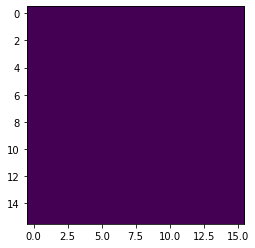

In [131]:
action_dict = {0: 'N', 1: 'S', 2: 'E', 3: 'W', 4: 'Search'}
action_dict_r = {action_dict[x]: x for x in action_dict.keys()}

import matplotlib.pyplot as plt

env = Hierarchical_Maze(16, 2, 4
                        , 2, False, False, 2, False
                        , 0)
# env=Normal_Maze(22)
print(env.goal_init_state)
print(env.maze)
plt.imshow(env.maze)
results = {}
counter = 0







In [160]:
subsample = nn.AvgPool2d(kernel_size=2, stride=2, ceil_mode=True)

In [9]:
l=
subsample(torch.tensor(env.maze).reshape(1,1,l,l))

[48.0, 6.0]

In [4]:
l1=env.maze.shape[0]
mz=torch.tensor(env.maze).reshape(1,1,l1,l1)
for y in range(1):

    l=7
    pov =pd = int(l / 2)
    mz=subsample(mz)
    l2=mz.shape[-1]
    plt.imshow(mz.detach().numpy().reshape(l2,l2))
    plt.show()
mz = F.pad(mz[:
               , :, :, :], pad=(pd, pd, pd, pd),
               value=1)

l2=mz.shape[-1]
plt.imshow(mz.detach().numpy().reshape(l2,l2))
plt.show()


# # if torch.sum(aloc).item() > 1:
# #     print('hang on a second')
# _, _, xc, yc = torch.where(aloc == torch.max(aloc))
# # print(aloc)
# # print(xc,yc)
# xc = xc[0]  #
# yc = yc[0]
# mz = mz[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]

# aloc = aloc[:, :, xc - pov:xc + pov + 1, yc - pov:yc + pov + 1]
# aloc = torch.ceil(aloc - torch.min(aloc))
# aloc[:, :, 3, 3] = -1
mz1 = torch.ceil(mz - torch.min(mz))
plt.imshow(mz.detach().numpy().reshape(l2,l2))
plt.show()
# mat_1 = mz.reshape(1, int(l ** 2))

# mat_2 = aloc.reshape(1, int(l ** 2))

NameError: name 'subsample' is not defined

11

In [22]:
for y in range(1):
    print(y)

0


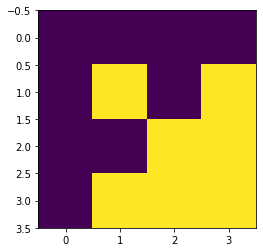

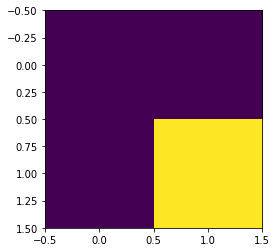

In [16]:
plt.imshow(l2.detach().numpy().reshape(2,2))


In [132]:
FlatQ = FlatHierarchicalQ(env)

#


In [87]:
# env.goal_init_state = [16,16]

  0%|                                                                                         | 0/8000 [00:00<?, ?it/s]

[96.0, 6.0]


C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:456: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[765]
[['E' 'E' 'E' 'E']
 ['E' 'E' 'E' 'E']
 ['E' 'E' 'E' 'E']
 ['Search' 'W' 'W' 'E']]
[[list([(0, -0.1474165916442871), (1, -0.17760829627513885), (2, -0.12929639220237732), (3, -0.16965614259243011)])
  list([(0, -0.12071089446544647), (1, -0.14466266334056854), (2, -0.1070161908864975), (3, -0.15086950361728668)])
  list([(0, -0.10665330290794373), (1, -0.10743483901023865), (2, -0.09528210759162903), (3, -0.13199764490127563)])
  list([(0, -0.10882170498371124), (1, -0.1294853389263153), (2, -0.08921508491039276), (3, -0.13341465592384338)])]
 [list([(0, -0.1383303850889206), (1, -0.17398710548877716), (2, -0.1193465143442154), (3, -0.14572302997112274)])
  list([(0, -0.10557259619235992), (1, -0.13454172015190125), (2, -0.0927998274564743), (3, -0.11299459636211395)])
  list([(0, -0.08514663577079773), (1, -0.07742168009281158), (2, -0.07192434370517731), (3, -0.08666259050369263)])
  list([(0, -0.09881457686424255), (1, -0.10134846717119217), (2, -0.07079306989908218), (3, -0.11

C:\Users\howar\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:556: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[['S' 'N' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['S' 'N' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['E' 'N' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'S' 'S']
 ['E' 'N' 'S' 'S' 'E' 'N' 'N' 'S' 'E' 'N' 'N' 'S' 'E' 'N' 'S' 'S']
 ['E' 'N' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['E' 'N' 'S' 'S' 'E' 'S' 'S' 'S' 'E' 'S' 'S' 'S' 'E' 'N' 'S' 'S']
 ['E' 'N' 'S' 'S' 'E' 'N' 'N' 'S' 'E' 'N' 'N' 'S' 'E' 'N' 'S' 'S']
 ['E' 'N' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['E' 'N' 'S' 'S' 'E' 'S' 'S' 'S' 'E' 'S' 'S' 'S' 'E' 'N' 'S' 'S']
 ['E' 'N' 'S' 'S' 'E' 'N' 'N' 'S' 'E' 'N' 'N' 'S' 'E' 'N' 'S' 'S']
 ['E' 'N' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S']
 ['E' 'E' 'S' 'S' 'E' 'S' 'S' 'S' 'E' 'S' 'S' 'S' 'E' 'S' 'S' 'S']
 ['E' 'N' 'W' 'W' 'E' 'N' 'W' 'W' 'E' 'N' 'W' 'W' 'E' 'W' 'W' 

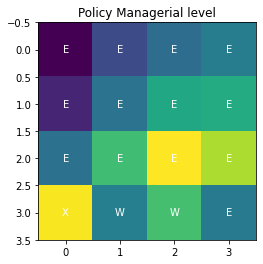

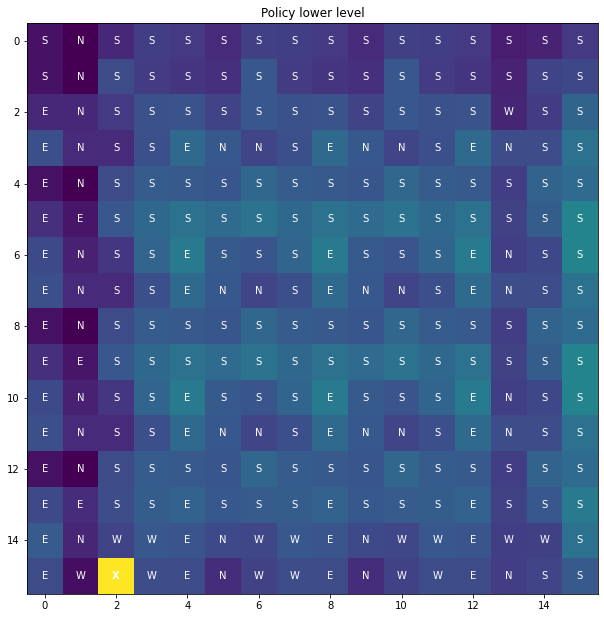

  0%|                                                                              | 1/8000 [00:11<24:51:40, 11.19s/it]

cccc
[765]
epsilon 0.75


  1%|▍                                                                             | 50/8000 [04:09<6:10:29,  2.80s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7]
epsilon 0.744609375


  1%|▉                                                                            | 101/8000 [06:39<4:04:24,  1.86s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18]
epsilon 0.73921875


  2%|█▍                                                                           | 151/8000 [09:19<6:40:13,  3.06s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172]
epsilon 0.733828125


  3%|█▉                                                                           | 201/8000 [11:45<9:26:55,  4.36s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858]
epsilon 0.7284375


  3%|██▍                                                                          | 250/8000 [13:42<2:41:21,  1.25s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

  4%|██▉                                                                          | 300/8000 [15:33<4:25:21,  2.07s/it]

[['E' 'E' 'E' 'E']
 ['E' 'S' 'W' 'E']
 ['S' 'S' 'W' 'E']
 ['Search' 'S' 'S' 'S']]
[[list([(0, -43.94540786743164), (1, -44.95939254760742), (2, -43.34354019165039), (3, -45.503562927246094)])
  list([(0, -62.44585037231445), (1, -61.70023727416992), (2, -60.978851318359375), (3, -62.47186279296875)])
  list([(0, -65.26126861572266), (1, -66.32650756835938), (2, -64.89838409423828), (3, -66.1444091796875)])
  list([(0, -60.18268966674805), (1, -61.9905891418457), (2, -58.40925979614258), (3, -61.80829620361328)])]
 [list([(0, -22.36919593811035), (1, -21.709829330444336), (2, -21.431392669677734), (3, -22.756258010864258)])
  list([(0, -34.83020782470703), (1, -33.54037857055664), (2, -34.51743698120117), (3, -34.0444221496582)])
  list([(0, -38.76731872558594), (1, -39.376102447509766), (2, -40.368473052978516), (3, -38.6408805847168)])
  list([(0, -51.133697509765625), (1, -52.56803512573242), (2, -50.908294677734375), (3, -52.013526916503906)])]
 [list([(0, -8.660041809082031), (1, -

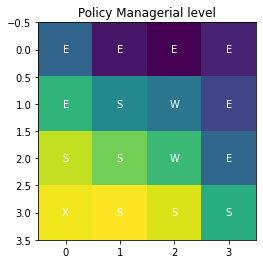

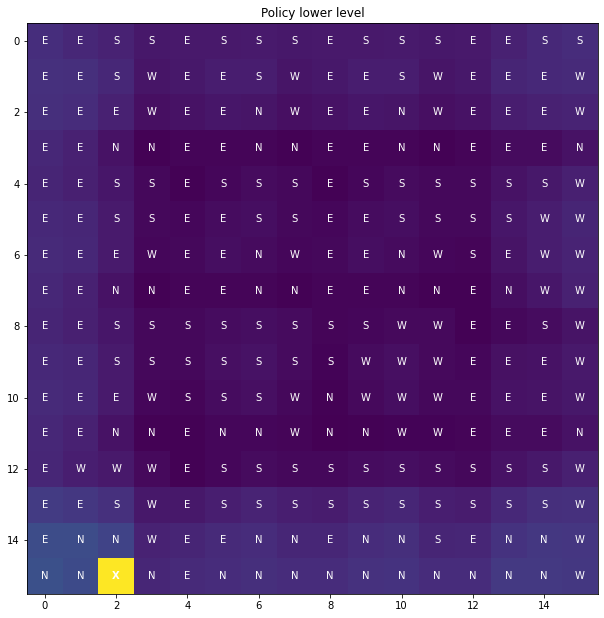

  4%|██▊                                                                         | 301/8000 [15:47<11:41:40,  5.47s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

  4%|███▍                                                                         | 351/8000 [17:56<6:53:57,  3.25s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

  5%|███▊                                                                         | 401/8000 [20:46<4:39:22,  2.21s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

  6%|████▎                                                                        | 451/8000 [23:25<5:50:57,  2.79s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

  6%|████▊                                                                        | 501/8000 [25:38<6:16:44,  3.01s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

  7%|█████▎                                                                       | 551/8000 [27:07<2:02:45,  1.01it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

  8%|█████▊                                                                       | 600/8000 [28:46<3:53:38,  1.89s/it]

[['E' 'E' 'N' 'E']
 ['S' 'E' 'N' 'E']
 ['W' 'E' 'W' 'E']
 ['Search' 'S' 'S' 'E']]
[[list([(0, -20.355121612548828), (1, -21.38824462890625), (2, -20.177017211914062), (3, -21.72561264038086)])
  list([(0, -23.292747497558594), (1, -24.53249168395996), (2, -22.005327224731445), (3, -24.759723663330078)])
  list([(0, -21.190059661865234), (1, -23.32509422302246), (2, -22.9425106048584), (3, -24.320755004882812)])
  list([(0, -21.14571189880371), (1, -20.413915634155273), (2, -17.48331642150879), (3, -20.480937957763672)])]
 [list([(0, -12.66004753112793), (1, -11.547381401062012), (2, -11.990047454833984), (3, -12.419892311096191)])
  list([(0, -14.33566665649414), (1, -14.087904930114746), (2, -11.86623764038086), (3, -14.834120750427246)])
  list([(0, -12.009926795959473), (1, -12.137167930603027), (2, -14.491032600402832), (3, -14.231314659118652)])
  list([(0, -15.961464881896973), (1, -14.856528282165527), (2, -12.421175003051758), (3, -15.567339897155762)])]
 [list([(0, -4.94002819

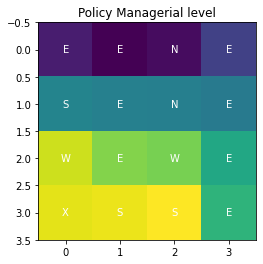

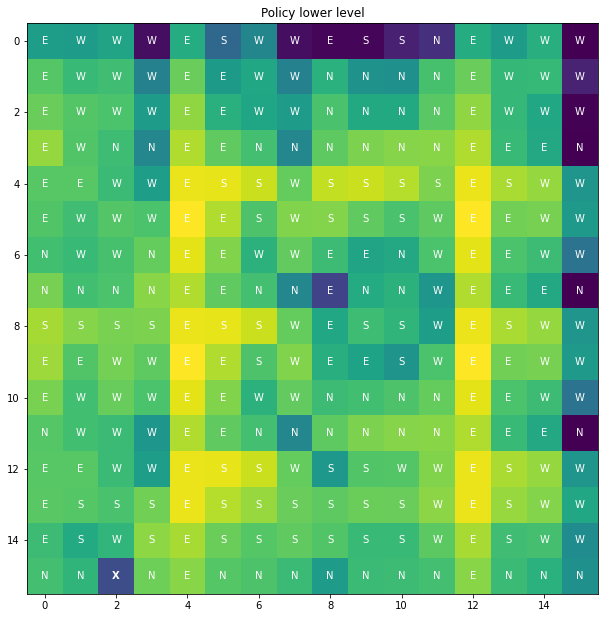

  8%|█████▊                                                                       | 601/8000 [28:51<5:43:19,  2.78s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

  8%|██████▎                                                                      | 651/8000 [30:07<3:12:57,  1.58s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

  9%|██████▋                                                                      | 701/8000 [32:08<3:51:38,  1.90s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

  9%|███████▏                                                                     | 751/8000 [34:09<6:24:44,  3.18s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 10%|███████▋                                                                     | 801/8000 [35:36<2:41:57,  1.35s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 11%|████████▏                                                                    | 851/8000 [36:40<2:51:05,  1.44s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 11%|████████▋                                                                    | 900/8000 [37:36<2:36:53,  1.33s/it]

[['N' 'N' 'N' 'E']
 ['W' 'E' 'S' 'E']
 ['W' 'E' 'S' 'E']
 ['Search' 'S' 'S' 'S']]
[[list([(0, -11.364672660827637), (1, -13.222189903259277), (2, -13.506424903869629), (3, -11.863463401794434)])
  list([(0, -18.649253845214844), (1, -20.884843826293945), (2, -20.570804595947266), (3, -20.46636962890625)])
  list([(0, -14.91438102722168), (1, -18.38799476623535), (2, -18.496309280395508), (3, -18.822227478027344)])
  list([(0, -12.43316650390625), (1, -13.836203575134277), (2, -11.301217079162598), (3, -12.95544147491455)])]
 [list([(0, -9.594564437866211), (1, -9.374401092529297), (2, -9.282625198364258), (3, -6.998970985412598)])
  list([(0, -22.0197696685791), (1, -20.87244415283203), (2, -20.065753936767578), (3, -21.126964569091797)])
  list([(0, -18.662832260131836), (1, -17.950956344604492), (2, -19.0693359375), (3, -19.3348445892334)])
  list([(0, -13.495455741882324), (1, -13.704967498779297), (2, -11.716100692749023), (3, -13.589614868164062)])]
 [list([(0, 2.2568912506103516)

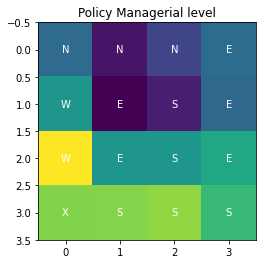

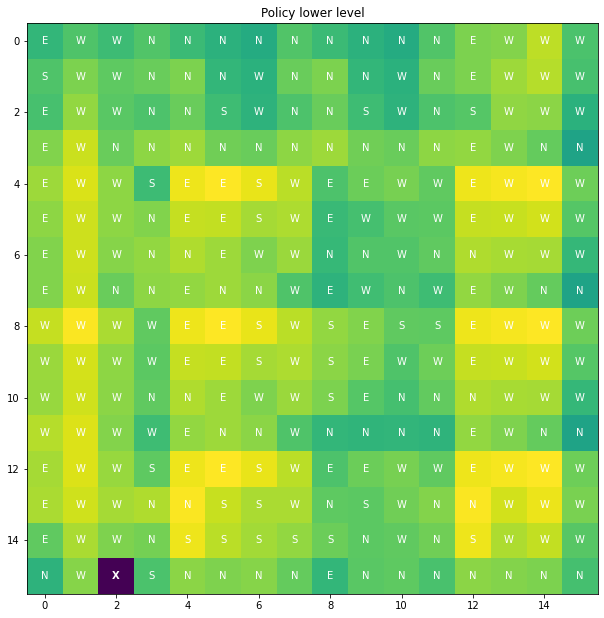

 11%|████████▋                                                                    | 901/8000 [37:41<4:41:10,  2.38s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 12%|█████████▏                                                                   | 951/8000 [38:48<2:15:41,  1.16s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 13%|█████████▌                                                                  | 1001/8000 [39:52<2:55:50,  1.51s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 13%|█████████▉                                                                  | 1051/8000 [40:55<2:39:00,  1.37s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 14%|██████████▍                                                                 | 1101/8000 [42:04<1:27:46,  1.31it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 14%|██████████▉                                                                 | 1151/8000 [43:00<1:32:17,  1.24it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 15%|███████████▍                                                                | 1200/8000 [43:57<1:43:56,  1.09it/s]

[['N' 'N' 'N' 'N']
 ['W' 'E' 'S' 'E']
 ['W' 'E' 'S' 'E']
 ['Search' 'S' 'S' 'S']]
[[list([(0, -17.714359283447266), (1, -19.404876708984375), (2, -19.821245193481445), (3, -19.40522575378418)])
  list([(0, -41.52217483520508), (1, -44.84419250488281), (2, -44.98076629638672), (3, -44.63850402832031)])
  list([(0, -25.04102325439453), (1, -28.36924171447754), (2, -28.923725128173828), (3, -28.92055892944336)])
  list([(0, -5.722402095794678), (1, -6.7708868980407715), (2, -5.96021842956543), (3, -6.234984874725342)])]
 [list([(0, -43.27299118041992), (1, -43.585453033447266), (2, -43.80339431762695), (3, -41.423683166503906)])
  list([(0, -103.60486602783203), (1, -103.88163757324219), (2, -103.00899505615234), (3, -103.52819061279297)])
  list([(0, -85.60993194580078), (1, -85.24784088134766), (2, -85.78772735595703), (3, -86.1549072265625)])
  list([(0, -29.4180965423584), (1, -29.766809463500977), (2, -26.542360305786133), (3, -29.149505615234375)])]
 [list([(0, -1.647221565246582), 

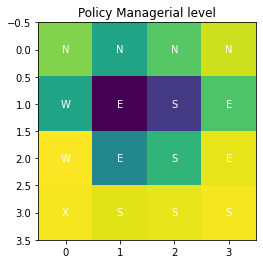

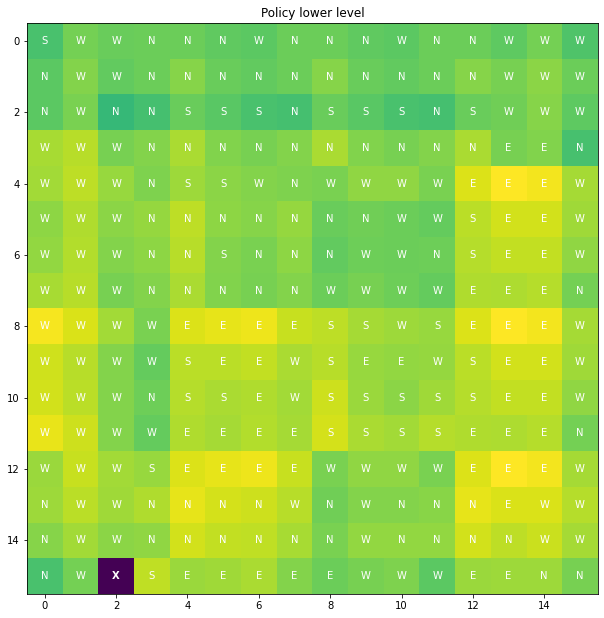

 15%|███████████▍                                                                | 1201/8000 [44:02<3:56:01,  2.08s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 16%|███████████▉                                                                | 1251/8000 [44:49<1:33:44,  1.20it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 16%|████████████▎                                                               | 1301/8000 [45:42<2:50:41,  1.53s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 17%|████████████▊                                                               | 1351/8000 [46:26<1:47:16,  1.03it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 18%|█████████████▎                                                              | 1401/8000 [47:11<1:40:39,  1.09it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 18%|█████████████▊                                                              | 1451/8000 [48:00<2:01:26,  1.11s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 19%|██████████████▎                                                             | 1500/8000 [48:44<2:18:23,  1.28s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

[['S' 'S' 'S' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W']
 ['W' 'W' 'W' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'N' 'W' 'W' 'W']
 ['W' 'W' 'W' 'N' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'N' 'W']
 ['W' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['W' 'W' 'W' 'W' 'S' 'S' 'W' 'W' 'S' 'S' 'W' 'W' 'S' 'W' 'W' 'W']
 ['N' 'W' 'W' 'N' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'N' 'W' 'W' 'W']
 ['N' 'W' 'W' 'N' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'N' 'W' 'N' 'N']
 ['N' 'W' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N']
 ['W' 'W' 'W' 'W' 'S' 'S' 'W' 'W' 'S' 'S' 'W' 'W' 'E' 'S' 'W' 'W']
 ['W' 'W' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W' 'E' 'W' 'E' 'W']
 ['W' 'W' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W' 'N' 'N']
 ['W' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['S' 'S' 'W' 'W' 'E' 'S' 'S' 'W' 'S' 'S' 'W' 'W' 'S' 'W' 'W' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 

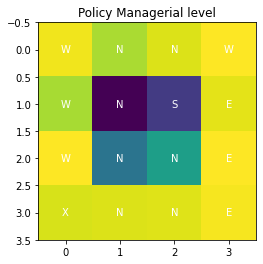

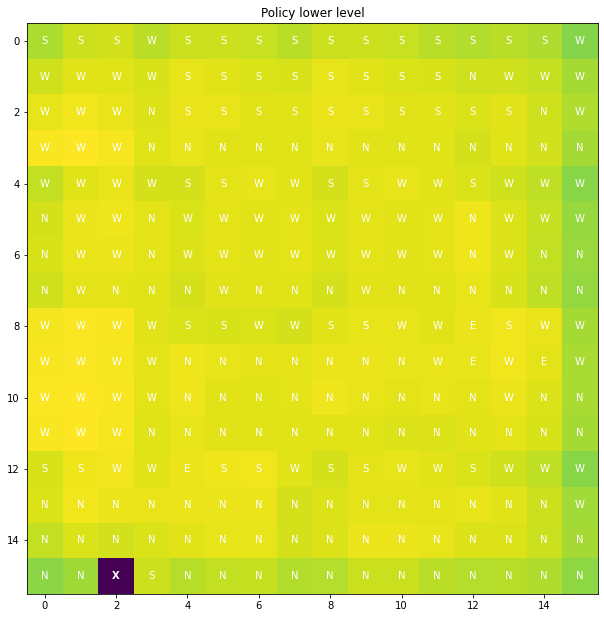

 19%|██████████████▎                                                             | 1501/8000 [48:48<3:48:14,  2.11s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 19%|██████████████▋                                                             | 1551/8000 [49:23<1:27:44,  1.22it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 20%|███████████████▌                                                              | 1602/8000 [50:11<42:08,  2.53it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 21%|███████████████▋                                                            | 1651/8000 [50:50<1:37:23,  1.09it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 21%|████████████████▏                                                           | 1701/8000 [51:29<1:45:28,  1.00s/it]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 22%|████████████████▋                                                           | 1751/8000 [52:03<1:01:05,  1.70it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 22%|█████████████████                                                           | 1800/8000 [52:41<2:12:15,  1.28s/it]

[['W' 'S' 'S' 'W']
 ['W' 'W' 'S' 'W']
 ['N' 'N' 'S' 'E']
 ['Search' 'N' 'N' 'E']]
[[list([(0, 15.468606948852539), (1, 17.34789276123047), (2, 18.260908126831055), (3, 20.42182159423828)])
  list([(0, 1.0075411796569824), (1, 9.521149635314941), (2, 6.309348106384277), (3, 5.594003200531006)])
  list([(0, 27.337867736816406), (1, 36.156646728515625), (2, 30.516592025756836), (3, 32.56364059448242)])
  list([(0, 30.868942260742188), (1, 34.218849182128906), (2, 34.363250732421875), (3, 40.203609466552734)])]
 [list([(0, 2.842423915863037), (1, 1.1996098756790161), (2, 2.7401440143585205), (3, 4.006379127502441)])
  list([(0, -218.5698699951172), (1, -217.83128356933594), (2, -217.5238494873047), (3, -216.83688354492188)])
  list([(0, -177.36260986328125), (1, -167.91627502441406), (2, -170.2410430908203), (3, -172.90476989746094)])
  list([(0, 34.974700927734375), (1, 29.67866325378418), (2, 37.619075775146484), (3, 38.79277038574219)])]
 [list([(0, 18.140661239624023), (1, 5.0777573585

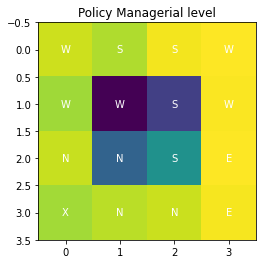

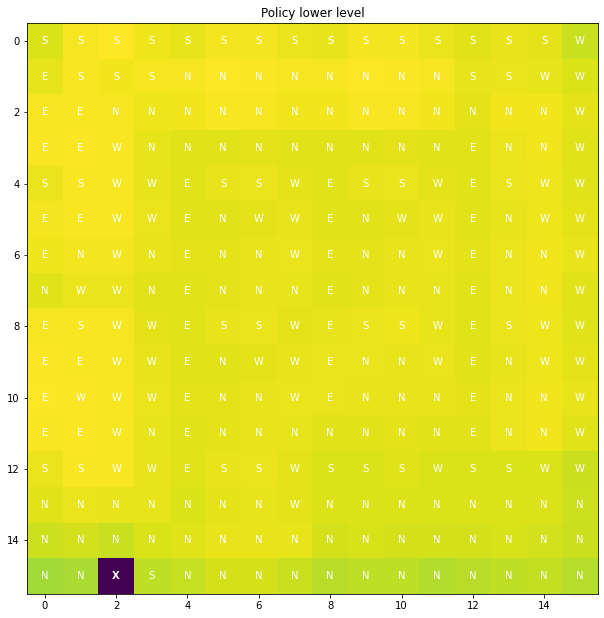

 23%|█████████████████                                                           | 1801/8000 [52:44<3:19:26,  1.93s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 23%|█████████████████▌                                                          | 1851/8000 [53:22<1:22:33,  1.24it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 24%|██████████████████                                                          | 1901/8000 [54:00<1:07:35,  1.50it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 24%|██████████████████▌                                                         | 1951/8000 [54:36<1:05:42,  1.53it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 25%|███████████████████▌                                                          | 2001/8000 [55:00<23:15,  4.30it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 26%|███████████████████▍                                                        | 2051/8000 [55:31<1:01:10,  1.62it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 26%|███████████████████▉                                                        | 2100/8000 [56:09<1:05:20,  1.50it/s]

[['E' 'S' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['N' 'N' 'S' 'E']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 28.50135040283203), (1, 29.686193466186523), (2, 36.15826416015625), (3, 33.251216888427734)])
  list([(0, 17.157529830932617), (1, 31.757802963256836), (2, 29.117403030395508), (3, 27.011260986328125)])
  list([(0, 43.67020034790039), (1, 55.39894485473633), (2, 50.6342887878418), (3, 53.4577751159668)])
  list([(0, 54.41526794433594), (1, 56.09018325805664), (2, 59.4686164855957), (3, 67.88787078857422)])]
 [list([(0, 19.650699615478516), (1, 13.118171691894531), (2, 20.50478744506836), (3, 13.694354057312012)])
  list([(0, -181.78799438476562), (1, -179.93226623535156), (2, -179.88922119140625), (3, -181.70944213867188)])
  list([(0, -152.1192626953125), (1, -136.67123413085938), (2, -142.08981323242188), (3, -144.88601684570312)])
  list([(0, 64.02474212646484), (1, 53.83845138549805), (2, 66.30284881591797), (3, 70.33262634277344)])]
 [list([(0, 35.546749114990234), (1, 11.255544662475586

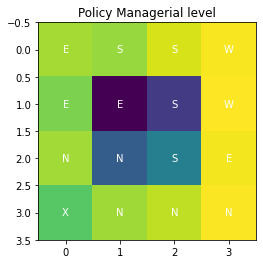

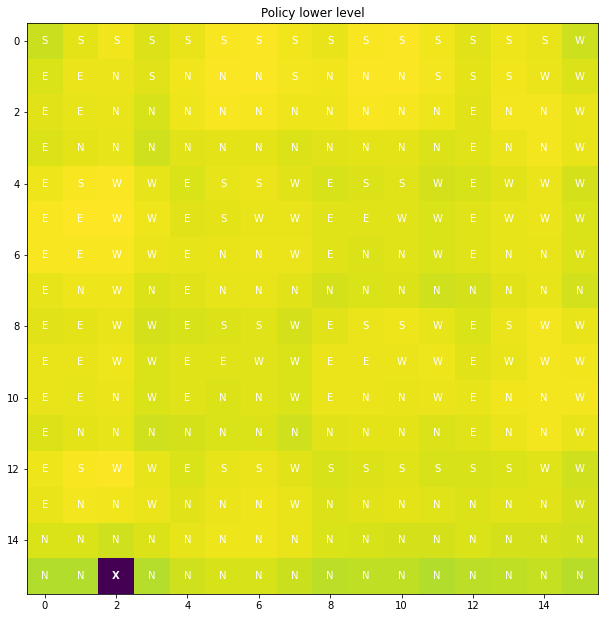

 26%|███████████████████▉                                                        | 2101/8000 [56:12<2:30:05,  1.53s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 27%|████████████████████▉                                                         | 2151/8000 [56:43<41:35,  2.34it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 28%|█████████████████████▍                                                        | 2201/8000 [57:12<44:45,  2.16it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 28%|█████████████████████▍                                                      | 2251/8000 [57:42<1:07:07,  1.43it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 29%|██████████████████████▍                                                       | 2301/8000 [58:09<52:25,  1.81it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 29%|██████████████████████▉                                                       | 2351/8000 [58:37<45:02,  2.09it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 30%|██████████████████████▊                                                     | 2400/8000 [59:03<1:00:33,  1.54it/s]

[['E' 'S' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['N' 'N' 'S' 'E']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 110.53641510009766), (1, 122.46380615234375), (2, 129.15475463867188), (3, 119.35541534423828)])
  list([(0, 161.68548583984375), (1, 202.39959716796875), (2, 180.6247100830078), (3, 185.9247589111328)])
  list([(0, 166.55445861816406), (1, 211.5967559814453), (2, 179.97158813476562), (3, 194.1918182373047)])
  list([(0, 147.2898406982422), (1, 156.9390869140625), (2, 156.5626220703125), (3, 180.71421813964844)])]
 [list([(0, 107.35686492919922), (1, 84.31839752197266), (2, 111.31279754638672), (3, 85.53324890136719)])
  list([(0, -13.685022354125977), (1, -14.279865264892578), (2, -12.16378116607666), (3, -15.32683277130127)])
  list([(0, -26.671926498413086), (1, 3.050567150115967), (2, -11.626496315002441), (3, -6.2058820724487305)])
  list([(0, 155.82015991210938), (1, 127.629638671875), (2, 153.74024963378906), (3, 168.32310485839844)])]
 [list([(0, 90.604736328125), (1, 34.02846908569336

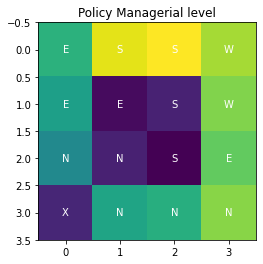

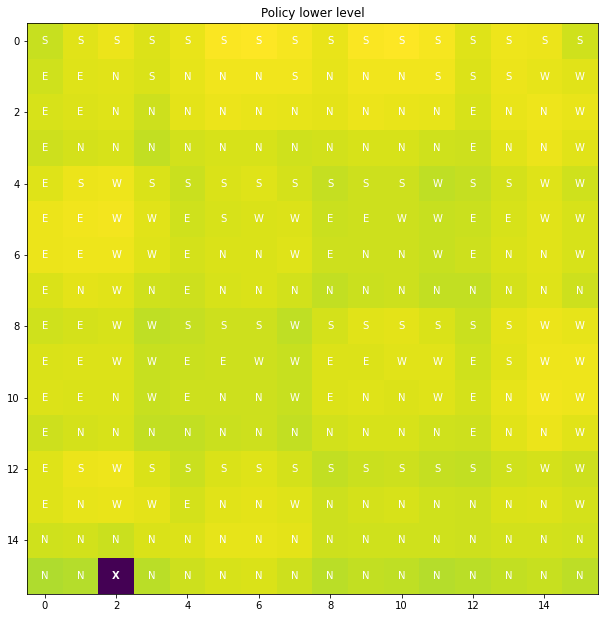

 30%|██████████████████████▊                                                     | 2401/8000 [59:07<2:32:42,  1.64s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 31%|███████████████████████▉                                                      | 2451/8000 [59:31<36:30,  2.53it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 31%|████████████████████████▍                                                     | 2502/8000 [59:52<31:40,  2.89it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 32%|████████████████████████▏                                                   | 2551/8000 [1:00:13<47:56,  1.89it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 33%|████████████████████████▋                                                   | 2601/8000 [1:00:33<31:47,  2.83it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 33%|█████████████████████████▏                                                  | 2651/8000 [1:00:58<48:02,  1.86it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 34%|█████████████████████████▋                                                  | 2699/8000 [1:01:17<27:53,  3.17it/s]

[['E' 'S' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['N' 'N' 'S' 'N']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 162.56573486328125), (1, 180.28744506835938), (2, 185.00765991210938), (3, 172.4022674560547)])
  list([(0, 242.2969207763672), (1, 293.1883850097656), (2, 267.7950744628906), (3, 278.4548645019531)])
  list([(0, 249.0911102294922), (1, 309.40081787109375), (2, 271.9678039550781), (3, 286.0589599609375)])
  list([(0, 206.57542419433594), (1, 216.33279418945312), (2, 219.18478393554688), (3, 251.07611083984375)])]
 [list([(0, 154.19752502441406), (1, 128.86370849609375), (2, 157.40753173828125), (3, 119.88922119140625)])
  list([(0, 71.24699401855469), (1, 67.23609924316406), (2, 73.99864196777344), (3, 62.261573791503906)])
  list([(0, 48.51718521118164), (1, 83.44598388671875), (2, 68.2185287475586), (3, 74.04720306396484)])
  list([(0, 213.9429473876953), (1, 161.65638732910156), (2, 205.05282592773438), (3, 224.89630126953125)])]
 [list([(0, 118.62364959716797), (1, 43.43937301635742), (2, 

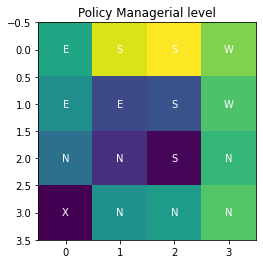

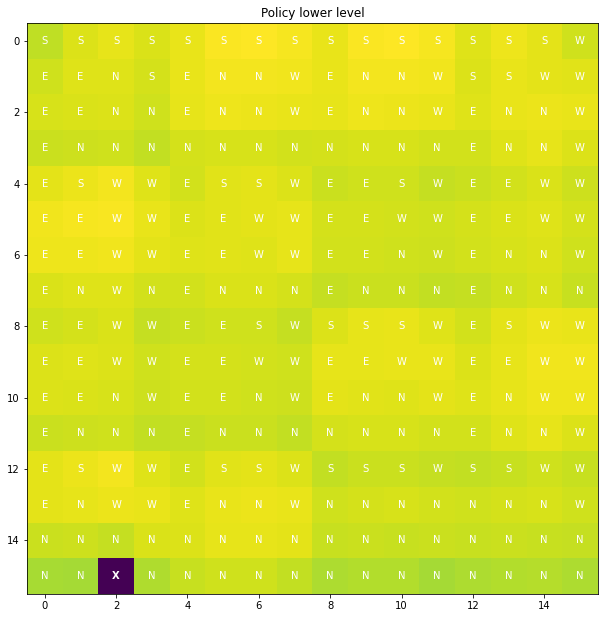

 34%|████████████████████████▉                                                 | 2701/8000 [1:01:21<1:02:33,  1.41it/s]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 34%|██████████████████████████▏                                                 | 2751/8000 [1:01:41<56:00,  1.56it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 35%|██████████████████████████▌                                                 | 2801/8000 [1:02:02<43:39,  1.99it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 36%|███████████████████████████                                                 | 2850/8000 [1:02:20<28:22,  3.03it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 36%|███████████████████████████▌                                                | 2902/8000 [1:02:37<26:13,  3.24it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 37%|████████████████████████████                                                | 2951/8000 [1:02:58<36:58,  2.28it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 38%|████████████████████████████▌                                               | 3000/8000 [1:03:17<32:28,  2.57it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

[['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W']
 ['E' 'S' 'W' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'W' 'W']
 ['E' 'N' 'N' 'W' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'W' 'E' 'N' 'W' 'W']
 ['E' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['S' 'S' 'W' 'S' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'S' 'W' 'W' 'E' 'E' 'W' 'W' 'E' 'W' 'W' 'W']
 ['E' 'W' 'W' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'N' 'W']
 ['E' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['E' 'E' 'W' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'E' 'W' 'W' 'E' 'S' 'W' 'W' 'E' 'W' 'W' 'W']
 ['E' 'E' 'N' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'W' 'W' 'E' 'N' 'W' 'W']
 ['E' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['S' 'S' 'W' 'S' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W']
 ['E' 'N' 'W' 'W' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 

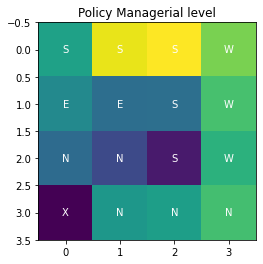

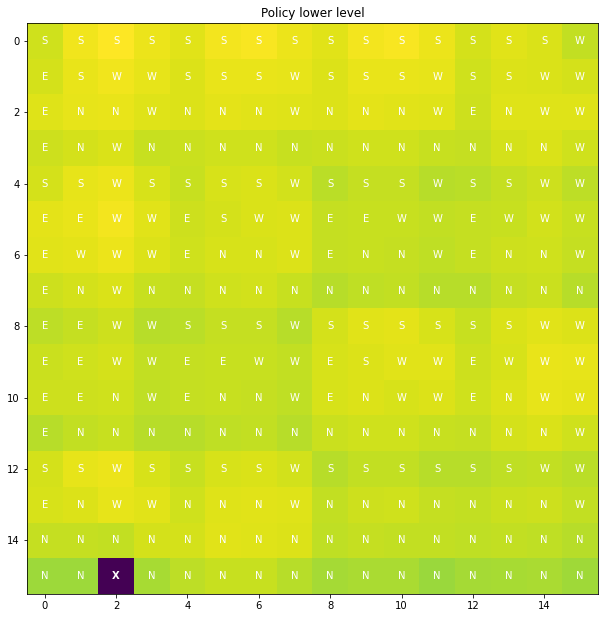

 38%|███████████████████████████▊                                              | 3001/8000 [1:03:21<1:55:01,  1.38s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 38%|████████████████████████████▉                                               | 3051/8000 [1:03:36<20:15,  4.07it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 39%|█████████████████████████████▍                                              | 3101/8000 [1:03:54<27:41,  2.95it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 39%|█████████████████████████████▉                                              | 3151/8000 [1:04:11<22:15,  3.63it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 40%|██████████████████████████████▍                                             | 3201/8000 [1:04:27<30:03,  2.66it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 41%|██████████████████████████████▉                                             | 3251/8000 [1:04:44<18:52,  4.19it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 41%|███████████████████████████████▎                                            | 3300/8000 [1:05:00<34:56,  2.24it/s]

[['S' 'S' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['N' 'N' 'S' 'W']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 283.60052490234375), (1, 339.3500061035156), (2, 337.6708068847656), (3, 326.753173828125)])
  list([(0, 440.537109375), (1, 570.8943481445312), (2, 500.9476623535156), (3, 531.178955078125)])
  list([(0, 440.858154296875), (1, 581.4221801757812), (2, 493.5066833496094), (3, 527.4295654296875)])
  list([(0, 352.5063171386719), (1, 418.3347473144531), (2, 397.55865478515625), (3, 462.13934326171875)])]
 [list([(0, 271.5997314453125), (1, 241.04490661621094), (2, 281.6869201660156), (3, 222.2494659423828)])
  list([(0, 258.08624267578125), (1, 255.52197265625), (2, 267.07232666015625), (3, 246.3483123779297)])
  list([(0, 192.90005493164062), (1, 267.4455261230469), (2, 228.13731384277344), (3, 246.95579528808594)])
  list([(0, 372.0056457519531), (1, 314.5260925292969), (2, 373.3346862792969), (3, 419.47021484375)])]
 [list([(0, 205.40914916992188), (1, 69.67859649658203), (2, 187.7324676513672

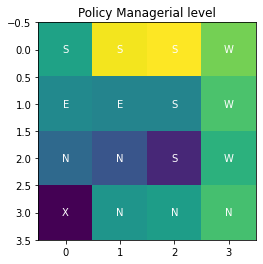

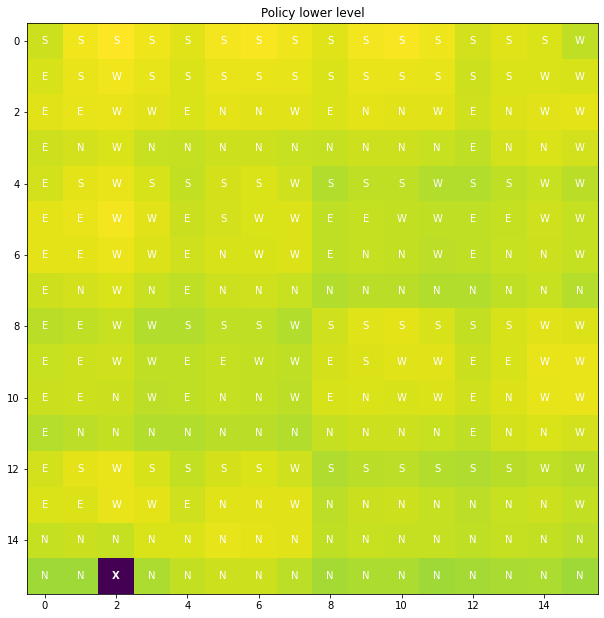

 41%|██████████████████████████████▌                                           | 3301/8000 [1:05:03<1:46:10,  1.36s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 42%|███████████████████████████████▊                                            | 3351/8000 [1:05:19<35:35,  2.18it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 43%|████████████████████████████████▎                                           | 3401/8000 [1:05:36<33:08,  2.31it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 43%|████████████████████████████████▊                                           | 3451/8000 [1:05:52<18:54,  4.01it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 44%|█████████████████████████████████▎                                          | 3501/8000 [1:06:09<27:42,  2.71it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 44%|█████████████████████████████████▋                                          | 3551/8000 [1:06:26<23:28,  3.16it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 45%|██████████████████████████████████▏                                         | 3600/8000 [1:06:41<24:59,  2.94it/s]

[['S' 'S' 'S' 'W']
 ['E' 'N' 'S' 'W']
 ['N' 'N' 'N' 'N']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 441.13714599609375), (1, 513.0428466796875), (2, 506.3351745605469), (3, 497.5262756347656)])
  list([(0, 678.186279296875), (1, 859.63623046875), (2, 755.47314453125), (3, 805.484130859375)])
  list([(0, 662.11328125), (1, 858.029296875), (2, 729.9210815429688), (3, 786.9159545898438)])
  list([(0, 518.5009765625), (1, 623.4204711914062), (2, 580.8212890625), (3, 675.8601684570312)])]
 [list([(0, 408.896728515625), (1, 354.4497985839844), (2, 409.35943603515625), (3, 331.3581237792969)])
  list([(0, 436.0635070800781), (1, 415.47088623046875), (2, 433.19000244140625), (3, 412.00274658203125)])
  list([(0, 329.5857238769531), (1, 421.53778076171875), (2, 364.6571350097656), (3, 405.43719482421875)])
  list([(0, 527.4454345703125), (1, 463.6689758300781), (2, 526.4064331054688), (3, 598.6717529296875)])]
 [list([(0, 301.70037841796875), (1, 97.86859893798828), (2, 262.3421630859375), (3, 187.84

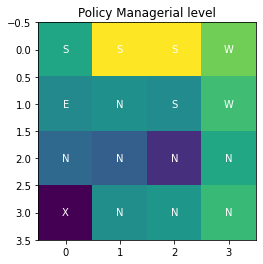

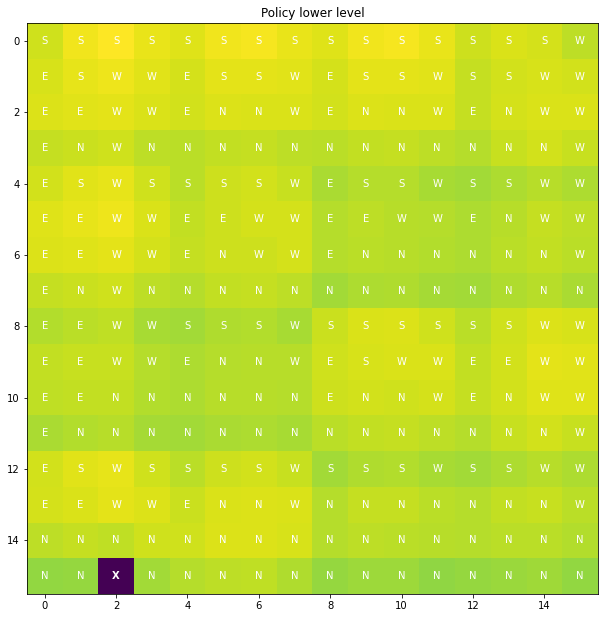

 45%|█████████████████████████████████▎                                        | 3601/8000 [1:06:44<1:27:50,  1.20s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 46%|██████████████████████████████████▋                                         | 3651/8000 [1:07:01<25:53,  2.80it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 46%|███████████████████████████████████▏                                        | 3701/8000 [1:07:15<17:40,  4.05it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 47%|███████████████████████████████████▋                                        | 3751/8000 [1:07:30<18:59,  3.73it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 48%|████████████████████████████████████                                        | 3801/8000 [1:07:44<17:15,  4.06it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 48%|████████████████████████████████████▌                                       | 3851/8000 [1:08:00<30:18,  2.28it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 49%|█████████████████████████████████████                                       | 3899/8000 [1:08:17<20:23,  3.35it/s]

[['S' 'S' 'S' 'W']
 ['N' 'N' 'S' 'W']
 ['N' 'N' 'S' 'E']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 496.99725341796875), (1, 589.9935302734375), (2, 573.1214599609375), (3, 565.4203491210938)])
  list([(0, 767.84130859375), (1, 986.1337890625), (2, 860.7135009765625), (3, 917.0223999023438)])
  list([(0, 747.1165161132812), (1, 981.20263671875), (2, 829.3471069335938), (3, 895.1340942382812)])
  list([(0, 571.5762329101562), (1, 711.0078125), (2, 650.8240966796875), (3, 756.8192749023438)])]
 [list([(0, 464.168212890625), (1, 411.0945129394531), (2, 463.8101806640625), (3, 376.3663024902344)])
  list([(0, 499.07281494140625), (1, 479.8924560546875), (2, 494.8238525390625), (3, 473.1412658691406)])
  list([(0, 376.66143798828125), (1, 483.8275451660156), (2, 417.49163818359375), (3, 466.7438659667969)])
  list([(0, 576.7508544921875), (1, 521.2857666015625), (2, 581.0843505859375), (3, 661.2509155273438)])]
 [list([(0, 347.40618896484375), (1, 127.13288116455078), (2, 301.30499267578125), (3,

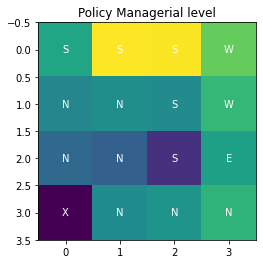

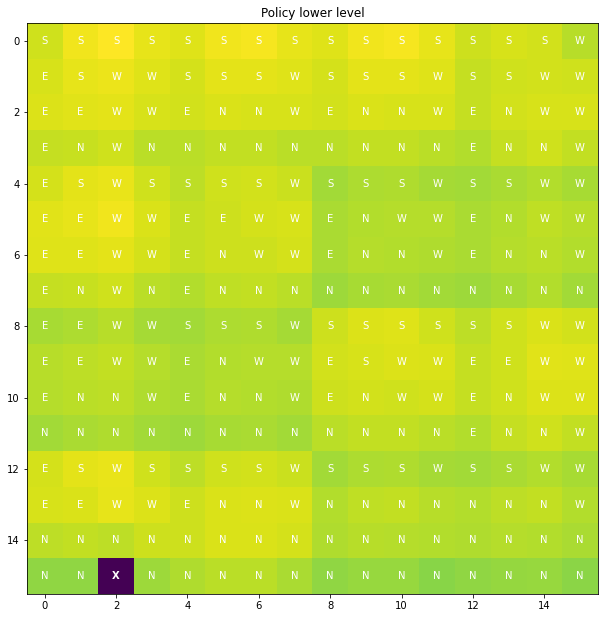

 49%|█████████████████████████████████████                                       | 3901/8000 [1:08:20<49:36,  1.38it/s]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 49%|█████████████████████████████████████▌                                      | 3951/8000 [1:08:35<24:07,  2.80it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 50%|██████████████████████████████████████                                      | 4001/8000 [1:08:51<27:34,  2.42it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 51%|██████████████████████████████████████▍                                     | 4051/8000 [1:09:06<19:52,  3.31it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 51%|██████████████████████████████████████▉                                     | 4101/8000 [1:09:20<15:02,  4.32it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 52%|███████████████████████████████████████▍                                    | 4151/8000 [1:09:37<23:30,  2.73it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 52%|███████████████████████████████████████▉                                    | 4200/8000 [1:09:49<14:14,  4.44it/s]

[['S' 'S' 'S' 'W']
 ['N' 'N' 'S' 'W']
 ['N' 'N' 'S' 'E']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 629.2706298828125), (1, 725.9140625), (2, 724.8975219726562), (3, 713.90625)])
  list([(0, 954.0852661132812), (1, 1215.2862548828125), (2, 1074.566162109375), (3, 1133.795166015625)])
  list([(0, 924.461181640625), (1, 1206.109130859375), (2, 1030.670654296875), (3, 1109.6103515625)])
  list([(0, 728.0750732421875), (1, 892.0439453125), (2, 829.4845581054688), (3, 956.7925415039062)])]
 [list([(0, 584.49267578125), (1, 495.1044921875), (2, 584.2603759765625), (3, 471.0639953613281)])
  list([(0, 637.19482421875), (1, 599.2978515625), (2, 636.0418090820312), (3, 607.4282836914062)])
  list([(0, 490.9136657714844), (1, 616.143798828125), (2, 544.135498046875), (3, 606.6876831054688)])
  list([(0, 734.6658935546875), (1, 670.9920654296875), (2, 747.9151000976562), (3, 849.7130737304688)])]
 [list([(0, 433.7411804199219), (1, 137.86216735839844), (2, 374.642333984375), (3, 260.9200134277344)])
  

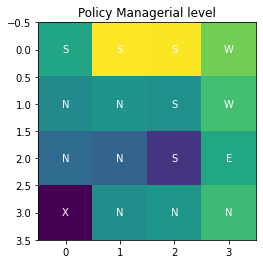

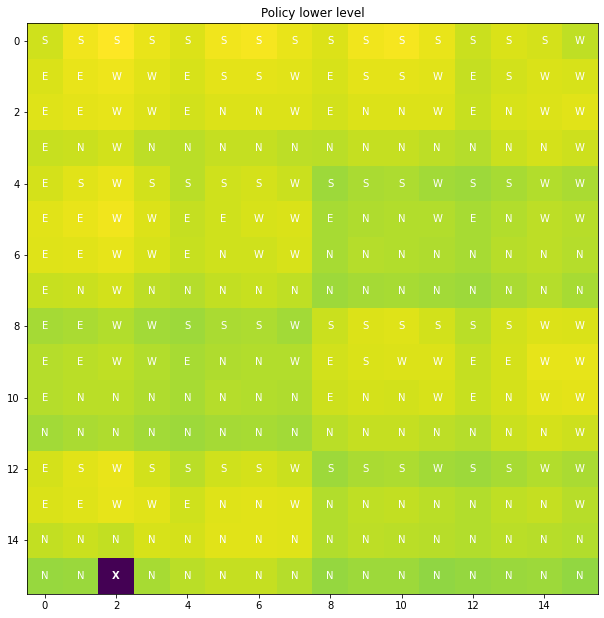

 53%|██████████████████████████████████████▊                                   | 4201/8000 [1:09:53<1:13:52,  1.17s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 53%|████████████████████████████████████████▍                                   | 4251/8000 [1:10:08<20:36,  3.03it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 54%|████████████████████████████████████████▊                                   | 4301/8000 [1:10:21<18:10,  3.39it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 54%|█████████████████████████████████████████▎                                  | 4351/8000 [1:10:38<23:27,  2.59it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 55%|█████████████████████████████████████████▊                                  | 4401/8000 [1:10:54<21:35,  2.78it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 56%|██████████████████████████████████████████▎                                 | 4451/8000 [1:11:09<20:00,  2.96it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 56%|██████████████████████████████████████████▊                                 | 4500/8000 [1:11:24<18:18,  3.19it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

[['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W']
 ['E' 'E' 'N' 'W' 'E' 'S' 'S' 'W' 'E' 'S' 'S' 'W' 'E' 'S' 'W' 'W']
 ['E' 'N' 'N' 'N' 'E' 'N' 'N' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'W' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['E' 'S' 'W' 'S' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'E' 'W' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'N' 'W']
 ['E' 'E' 'W' 'W' 'E' 'N' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['E' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['E' 'E' 'W' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'N' 'N' 'W' 'E' 'S' 'W' 'W' 'E' 'E' 'W' 'W']
 ['E' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'E' 'N' 'N' 'W' 'E' 'N' 'W' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['E' 'S' 'W' 'S' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'N' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 

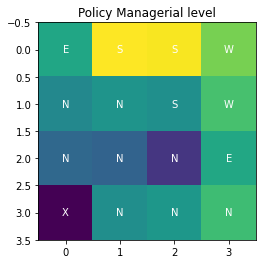

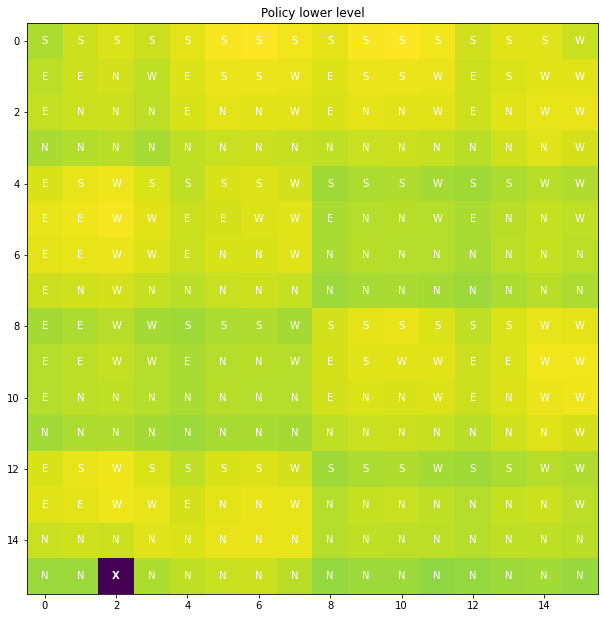

 56%|█████████████████████████████████████████▋                                | 4501/8000 [1:11:27<1:10:50,  1.21s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 57%|███████████████████████████████████████████▏                                | 4551/8000 [1:11:43<18:29,  3.11it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 58%|███████████████████████████████████████████▋                                | 4601/8000 [1:11:58<18:05,  3.13it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 58%|████████████████████████████████████████████▏                               | 4651/8000 [1:12:15<17:18,  3.22it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 59%|████████████████████████████████████████████▋                               | 4702/8000 [1:12:32<17:40,  3.11it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 59%|█████████████████████████████████████████████▏                              | 4751/8000 [1:12:46<17:32,  3.09it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 60%|█████████████████████████████████████████████▌                              | 4800/8000 [1:13:01<17:57,  2.97it/s]

[['S' 'S' 'S' 'W']
 ['E' 'E' 'W' 'W']
 ['N' 'N' 'S' 'E']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 903.12451171875), (1, 1040.41748046875), (2, 1039.914306640625), (3, 1010.4832153320312)])
  list([(0, 1332.60009765625), (1, 1698.677490234375), (2, 1497.819091796875), (3, 1589.0364990234375)])
  list([(0, 1274.88623046875), (1, 1671.406005859375), (2, 1424.7763671875), (3, 1545.005126953125)])
  list([(0, 1024.2069091796875), (1, 1271.6414794921875), (2, 1171.2398681640625), (3, 1354.3214111328125)])]
 [list([(0, 802.8324584960938), (1, 676.2947998046875), (2, 804.388671875), (3, 635.057373046875)])
  list([(0, 886.5057983398438), (1, 825.8226928710938), (2, 888.382568359375), (3, 870.5692138671875)])
  list([(0, 677.8250732421875), (1, 845.0054931640625), (2, 749.817626953125), (3, 848.74267578125)])
  list([(0, 1024.177001953125), (1, 979.9392700195312), (2, 1064.9827880859375), (3, 1214.27490234375)])]
 [list([(0, 592.2205810546875), (1, 167.4952850341797), (2, 505.82501220703125), (3, 3

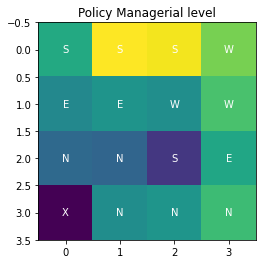

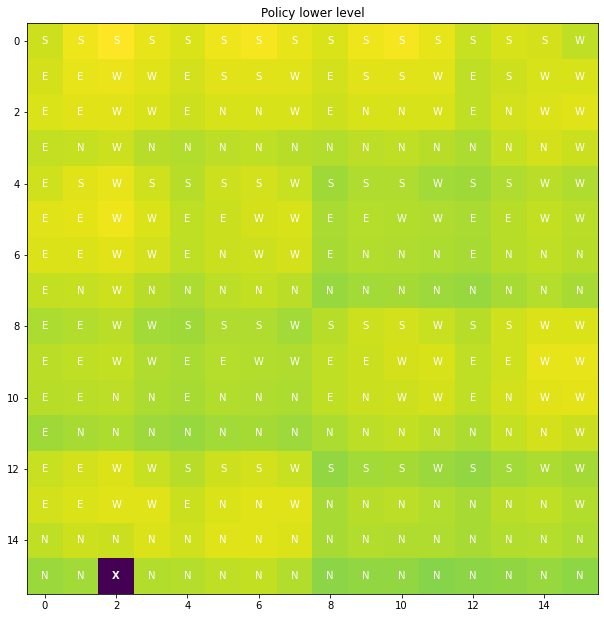

 60%|████████████████████████████████████████████▍                             | 4801/8000 [1:13:04<1:05:21,  1.23s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 61%|██████████████████████████████████████████████                              | 4851/8000 [1:13:20<13:55,  3.77it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 61%|██████████████████████████████████████████████▌                             | 4901/8000 [1:13:34<15:37,  3.30it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 62%|███████████████████████████████████████████████                             | 4951/8000 [1:13:48<16:56,  3.00it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 63%|███████████████████████████████████████████████▌                            | 5001/8000 [1:14:03<15:00,  3.33it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 63%|███████████████████████████████████████████████▉                            | 5051/8000 [1:14:18<15:50,  3.10it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 64%|████████████████████████████████████████████████▍                           | 5100/8000 [1:14:32<14:55,  3.24it/s]

[['S' 'S' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['N' 'N' 'S' 'W']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 937.3299560546875), (1, 1117.6025390625), (2, 1098.3717041015625), (3, 1059.5909423828125)])
  list([(0, 1421.512451171875), (1, 1856.2042236328125), (2, 1615.6055908203125), (3, 1723.277587890625)])
  list([(0, 1359.261474609375), (1, 1817.921630859375), (2, 1533.8990478515625), (3, 1673.4266357421875)])
  list([(0, 1055.4744873046875), (1, 1362.01953125), (2, 1228.8011474609375), (3, 1434.4017333984375)])]
 [list([(0, 849.3226318359375), (1, 728.5288696289062), (2, 854.1082763671875), (3, 659.6171264648438)])
  list([(0, 958.0528564453125), (1, 911.3176879882812), (2, 966.1973876953125), (3, 956.0001220703125)])
  list([(0, 721.441162109375), (1, 922.6011352539062), (2, 808.5997924804688), (3, 915.6838989257812)])
  list([(0, 1062.529296875), (1, 1044.7130126953125), (2, 1115.7001953125), (3, 1283.8045654296875)])]
 [list([(0, 630.4952392578125), (1, 154.24632263183594), (2, 528.545593261718

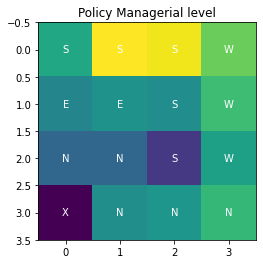

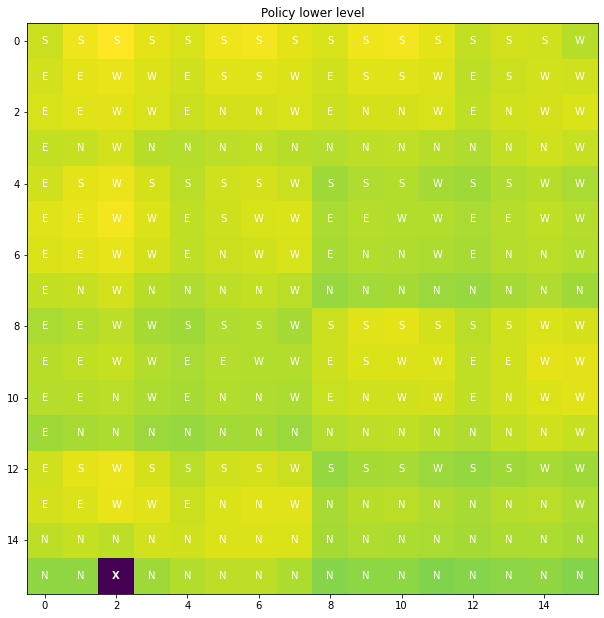

 64%|████████████████████████████████████████████████▍                           | 5101/8000 [1:14:36<58:06,  1.20s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 64%|████████████████████████████████████████████████▉                           | 5151/8000 [1:14:51<15:07,  3.14it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 65%|█████████████████████████████████████████████████▍                          | 5201/8000 [1:15:07<16:31,  2.82it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 66%|█████████████████████████████████████████████████▉                          | 5251/8000 [1:15:22<12:11,  3.76it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 66%|██████████████████████████████████████████████████▎                         | 5301/8000 [1:15:37<12:04,  3.73it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 67%|██████████████████████████████████████████████████▊                         | 5351/8000 [1:15:51<16:53,  2.61it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 68%|███████████████████████████████████████████████████▎                        | 5400/8000 [1:16:05<14:18,  3.03it/s]

[['S' 'S' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['N' 'N' 'S' 'W']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 1005.8187255859375), (1, 1239.2528076171875), (2, 1213.696044921875), (3, 1162.049560546875)])
  list([(0, 1589.107421875), (1, 2081.344482421875), (2, 1819.823974609375), (3, 1943.372314453125)])
  list([(0, 1525.410888671875), (1, 2023.8154296875), (2, 1726.0826416015625), (3, 1893.1463623046875)])
  list([(0, 1143.814208984375), (1, 1489.813720703125), (2, 1342.1685791015625), (3, 1603.2825927734375)])]
 [list([(0, 898.5505981445312), (1, 818.5031127929688), (2, 934.3434448242188), (3, 672.8314208984375)])
  list([(0, 1059.8179931640625), (1, 1040.7174072265625), (2, 1091.38427734375), (3, 1062.3011474609375)])
  list([(0, 809.5697021484375), (1, 1046.7552490234375), (2, 912.8187866210938), (3, 1026.83447265625)])
  list([(0, 1144.691162109375), (1, 1124.2803955078125), (2, 1203.765625), (3, 1417.873291015625)])]
 [list([(0, 655.8397216796875), (1, 151.46571350097656), (2, 558.6024780273438

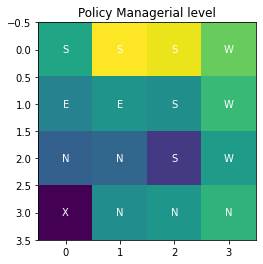

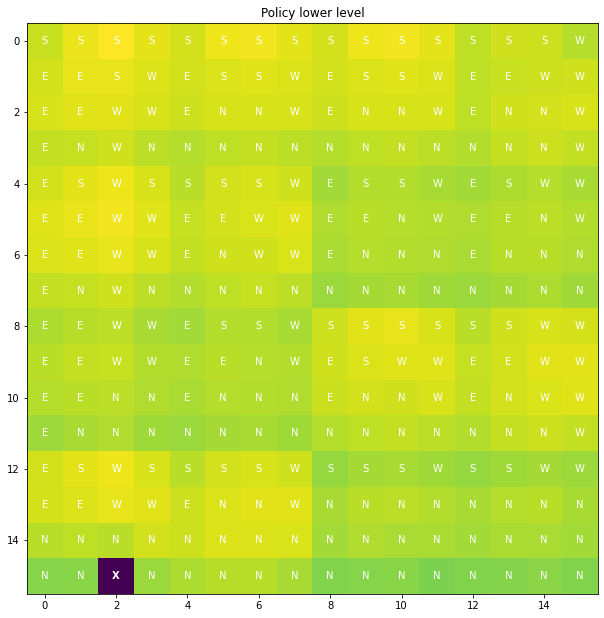

 68%|███████████████████████████████████████████████████▎                        | 5401/8000 [1:16:08<52:30,  1.21s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 68%|███████████████████████████████████████████████████▊                        | 5451/8000 [1:16:23<11:43,  3.63it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 69%|████████████████████████████████████████████████████▎                       | 5501/8000 [1:16:39<14:18,  2.91it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 69%|████████████████████████████████████████████████████▋                       | 5551/8000 [1:16:54<11:13,  3.64it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 70%|█████████████████████████████████████████████████████▏                      | 5601/8000 [1:17:10<11:17,  3.54it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 71%|█████████████████████████████████████████████████████▋                      | 5651/8000 [1:17:26<10:45,  3.64it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 71%|██████████████████████████████████████████████████████▏                     | 5700/8000 [1:17:39<09:50,  3.90it/s]

[['S' 'S' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['N' 'N' 'S' 'W']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 1049.8465576171875), (1, 1320.7705078125), (2, 1277.8861083984375), (3, 1240.2381591796875)])
  list([(0, 1661.596435546875), (1, 2198.811767578125), (2, 1910.1507568359375), (3, 2060.4970703125)])
  list([(0, 1599.5621337890625), (1, 2140.4755859375), (2, 1817.00341796875), (3, 2014.562744140625)])
  list([(0, 1198.57080078125), (1, 1585.7738037109375), (2, 1412.0921630859375), (3, 1711.73779296875)])]
 [list([(0, 931.0357666015625), (1, 875.0653076171875), (2, 977.3373413085938), (3, 710.9506225585938)])
  list([(0, 1106.6473388671875), (1, 1098.207763671875), (2, 1141.5994873046875), (3, 1124.6146240234375)])
  list([(0, 857.6117553710938), (1, 1112.8111572265625), (2, 964.9006958007812), (3, 1100.794677734375)])
  list([(0, 1196.7178955078125), (1, 1200.8861083984375), (2, 1264.2227783203125), (3, 1508.558349609375)])]
 [list([(0, 667.7130737304688), (1, 157.72857666015625), (2, 568.862487

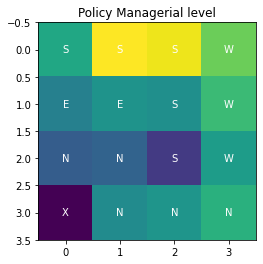

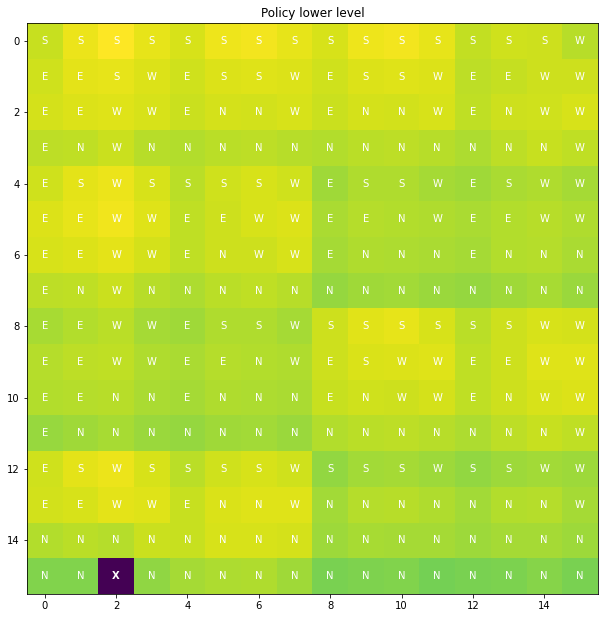

 71%|██████████████████████████████████████████████████████▏                     | 5701/8000 [1:17:43<42:43,  1.12s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 72%|██████████████████████████████████████████████████████▋                     | 5751/8000 [1:17:57<09:06,  4.11it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 73%|███████████████████████████████████████████████████████                     | 5801/8000 [1:18:12<12:48,  2.86it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 73%|███████████████████████████████████████████████████████▌                    | 5851/8000 [1:18:27<10:43,  3.34it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 74%|████████████████████████████████████████████████████████                    | 5901/8000 [1:18:42<10:13,  3.42it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 74%|████████████████████████████████████████████████████████▌                   | 5951/8000 [1:18:56<10:17,  3.32it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 75%|█████████████████████████████████████████████████████████                   | 6000/8000 [1:19:12<10:51,  3.07it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

[['S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W']
 ['E' 'E' 'W' 'W' 'E' 'S' 'S' 'W' 'E' 'S' 'S' 'W' 'E' 'E' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'W' 'W']
 ['E' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['E' 'S' 'W' 'S' 'S' 'S' 'S' 'W' 'E' 'S' 'S' 'W' 'E' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'E' 'W' 'W' 'E' 'E' 'W' 'W' 'E' 'E' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'N' 'W' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'N' 'W']
 ['E' 'N' 'W' 'N' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['E' 'E' 'W' 'W' 'E' 'S' 'S' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'E' 'W' 'W' 'E' 'E' 'W' 'W' 'E' 'E' 'W' 'W']
 ['E' 'E' 'N' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'W' 'W' 'E' 'N' 'W' 'W']
 ['E' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'W']
 ['E' 'E' 'W' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'N' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['N' 'N' 'N' 'W' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 

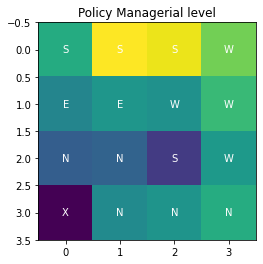

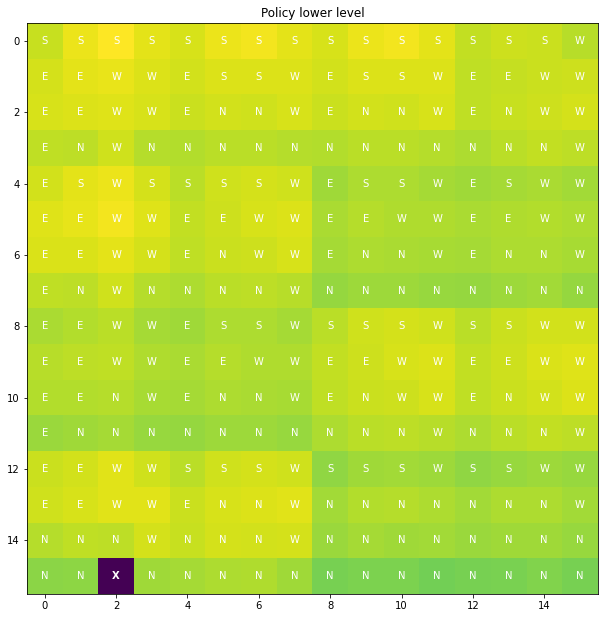

 75%|█████████████████████████████████████████████████████████                   | 6001/8000 [1:19:16<43:15,  1.30s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 76%|█████████████████████████████████████████████████████████▍                  | 6051/8000 [1:19:31<10:26,  3.11it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 76%|█████████████████████████████████████████████████████████▉                  | 6101/8000 [1:19:45<09:46,  3.24it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 77%|██████████████████████████████████████████████████████████▍                 | 6151/8000 [1:20:01<11:32,  2.67it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 78%|██████████████████████████████████████████████████████████▉                 | 6201/8000 [1:20:16<11:10,  2.68it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 78%|███████████████████████████████████████████████████████████▍                | 6251/8000 [1:20:31<10:37,  2.74it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 79%|███████████████████████████████████████████████████████████▊                | 6300/8000 [1:20:46<08:14,  3.44it/s]

[['S' 'S' 'S' 'W']
 ['E' 'E' 'W' 'W']
 ['N' 'N' 'S' 'W']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 1284.1865234375), (1, 1619.1524658203125), (2, 1583.189697265625), (3, 1554.3568115234375)])
  list([(0, 1972.8643798828125), (1, 2601.519287109375), (2, 2290.8544921875), (3, 2480.749267578125)])
  list([(0, 1892.616943359375), (1, 2522.045166015625), (2, 2172.590087890625), (3, 2425.684814453125)])
  list([(0, 1402.3131103515625), (1, 1877.029296875), (2, 1673.0242919921875), (3, 2053.002197265625)])]
 [list([(0, 1136.3707275390625), (1, 1083.5946044921875), (2, 1217.3897705078125), (3, 901.172119140625)])
  list([(0, 1326.9024658203125), (1, 1340.202880859375), (2, 1393.1817626953125), (3, 1362.2969970703125)])
  list([(0, 1032.8602294921875), (1, 1331.4775390625), (2, 1168.7437744140625), (3, 1335.9295654296875)])
  list([(0, 1382.3466796875), (1, 1422.97119140625), (2, 1481.4735107421875), (3, 1782.3133544921875)])]
 [list([(0, 807.0850830078125), (1, 213.7602996826172), (2, 702.645996093

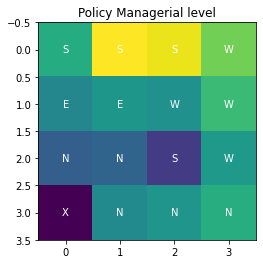

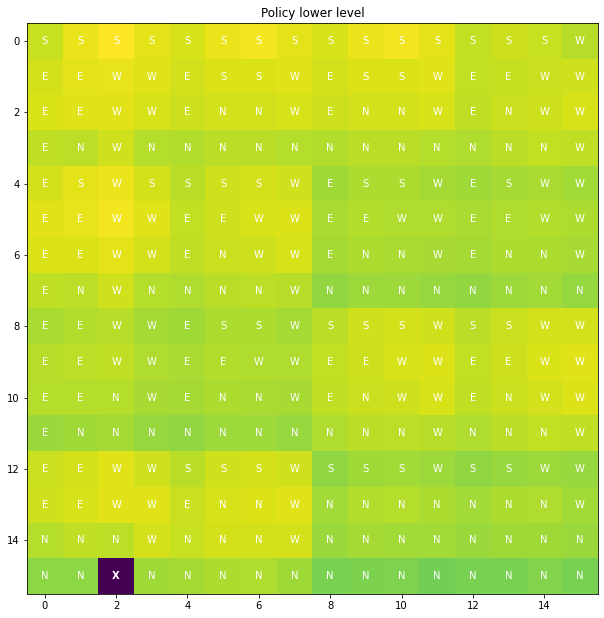

 79%|███████████████████████████████████████████████████████████▊                | 6301/8000 [1:20:50<34:38,  1.22s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 79%|████████████████████████████████████████████████████████████▎               | 6351/8000 [1:21:05<10:28,  2.62it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 80%|████████████████████████████████████████████████████████████▊               | 6401/8000 [1:21:20<07:32,  3.53it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 81%|█████████████████████████████████████████████████████████████▎              | 6451/8000 [1:21:35<08:03,  3.20it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 81%|█████████████████████████████████████████████████████████████▊              | 6501/8000 [1:21:49<07:23,  3.38it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 82%|██████████████████████████████████████████████████████████████▏             | 6551/8000 [1:22:05<06:51,  3.52it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 82%|██████████████████████████████████████████████████████████████▋             | 6600/8000 [1:22:21<07:50,  2.97it/s]

[['S' 'S' 'S' 'W']
 ['E' 'S' 'S' 'W']
 ['N' 'N' 'S' 'W']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 1372.2177734375), (1, 1749.5345458984375), (2, 1691.1165771484375), (3, 1649.693115234375)])
  list([(0, 2136.192626953125), (1, 2824.380126953125), (2, 2449.1064453125), (3, 2656.077392578125)])
  list([(0, 2033.573974609375), (1, 2705.06396484375), (2, 2293.378662109375), (3, 2578.265380859375)])
  list([(0, 1505.340576171875), (1, 2023.2725830078125), (2, 1765.1494140625), (3, 2192.777099609375)])]
 [list([(0, 1214.862060546875), (1, 1187.59765625), (2, 1311.571044921875), (3, 924.033447265625)])
  list([(0, 1454.517822265625), (1, 1534.5771484375), (2, 1532.6844482421875), (3, 1464.617431640625)])
  list([(0, 1116.743408203125), (1, 1461.5849609375), (2, 1247.8631591796875), (3, 1415.01904296875)])
  list([(0, 1517.67431640625), (1, 1573.656982421875), (2, 1590.3853759765625), (3, 1923.55029296875)])]
 [list([(0, 871.6942138671875), (1, 217.48306274414062), (2, 755.7833251953125), (3, 345.

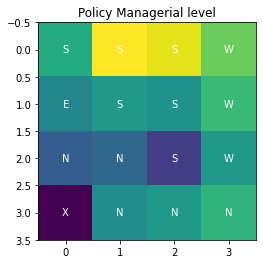

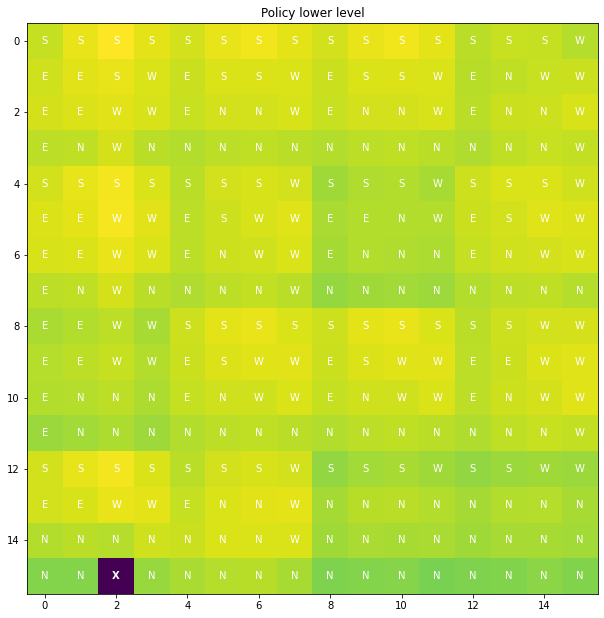

 83%|██████████████████████████████████████████████████████████████▋             | 6601/8000 [1:22:25<28:43,  1.23s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 83%|███████████████████████████████████████████████████████████████▏            | 6651/8000 [1:22:40<06:10,  3.64it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 84%|███████████████████████████████████████████████████████████████▋            | 6701/8000 [1:22:55<08:10,  2.65it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 84%|████████████████████████████████████████████████████████████████▏           | 6751/8000 [1:23:09<06:02,  3.45it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 85%|████████████████████████████████████████████████████████████████▌           | 6801/8000 [1:23:24<06:23,  3.12it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 86%|█████████████████████████████████████████████████████████████████           | 6851/8000 [1:23:40<06:04,  3.15it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 86%|█████████████████████████████████████████████████████████████████▌          | 6900/8000 [1:23:54<06:12,  2.95it/s]

[['S' 'S' 'S' 'W']
 ['E' 'S' 'S' 'W']
 ['N' 'N' 'S' 'W']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 1494.99853515625), (1, 1896.0262451171875), (2, 1837.986572265625), (3, 1802.8621826171875)])
  list([(0, 2317.6865234375), (1, 3062.563720703125), (2, 2656.947021484375), (3, 2888.574462890625)])
  list([(0, 2197.0732421875), (1, 2926.178955078125), (2, 2481.30224609375), (3, 2796.808837890625)])
  list([(0, 1654.739013671875), (1, 2239.1845703125), (2, 1943.765869140625), (3, 2397.665771484375)])]
 [list([(0, 1305.3836669921875), (1, 1276.8258056640625), (2, 1412.30810546875), (3, 998.5722045898438)])
  list([(0, 1586.45849609375), (1, 1674.8856201171875), (2, 1674.1376953125), (3, 1613.1865234375)])
  list([(0, 1217.505615234375), (1, 1587.0118408203125), (2, 1357.2265625), (3, 1542.3775634765625)])
  list([(0, 1666.869873046875), (1, 1760.5850830078125), (2, 1754.3194580078125), (3, 2097.225830078125)])]
 [list([(0, 918.8687744140625), (1, 203.39413452148438), (2, 795.8146362304688), (3, 3

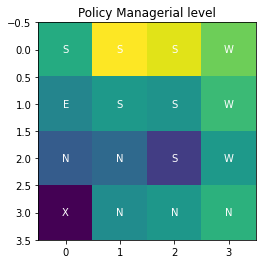

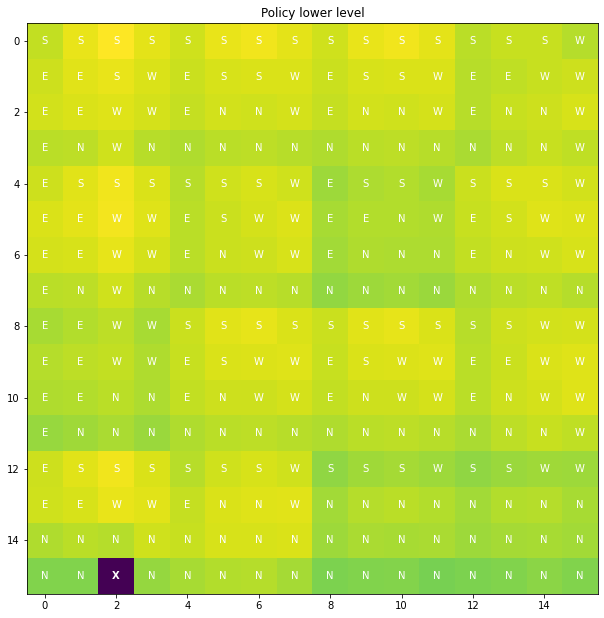

 86%|█████████████████████████████████████████████████████████████████▌          | 6901/8000 [1:23:58<24:48,  1.35s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 87%|██████████████████████████████████████████████████████████████████          | 6951/8000 [1:24:14<06:39,  2.63it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 88%|██████████████████████████████████████████████████████████████████▌         | 7001/8000 [1:24:30<04:58,  3.35it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 88%|██████████████████████████████████████████████████████████████████▉         | 7051/8000 [1:24:46<05:04,  3.12it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 89%|███████████████████████████████████████████████████████████████████▍        | 7101/8000 [1:25:01<05:56,  2.52it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 89%|███████████████████████████████████████████████████████████████████▉        | 7151/8000 [1:25:17<05:37,  2.51it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 90%|████████████████████████████████████████████████████████████████████▍       | 7200/8000 [1:25:32<04:17,  3.11it/s]

[['S' 'S' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['N' 'N' 'S' 'W']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 1642.0140380859375), (1, 2079.85009765625), (2, 2027.8861083984375), (3, 2004.6444091796875)])
  list([(0, 2503.739990234375), (1, 3306.905517578125), (2, 2898.353759765625), (3, 3153.666259765625)])
  list([(0, 2370.290771484375), (1, 3161.77685546875), (2, 2707.044921875), (3, 3049.1513671875)])
  list([(0, 1783.1304931640625), (1, 2429.82470703125), (2, 2118.01708984375), (3, 2604.735107421875)])]
 [list([(0, 1424.47998046875), (1, 1407.6988525390625), (2, 1552.8719482421875), (3, 1123.4940185546875)])
  list([(0, 1717.4947509765625), (1, 1812.2236328125), (2, 1829.806884765625), (3, 1785.2205810546875)])
  list([(0, 1327.8302001953125), (1, 1719.649658203125), (2, 1490.8265380859375), (3, 1691.83349609375)])
  list([(0, 1784.3848876953125), (1, 1912.210205078125), (2, 1899.7559814453125), (3, 2264.50439453125)])]
 [list([(0, 987.7515258789062), (1, 228.9126434326172), (2, 862.6096801757812

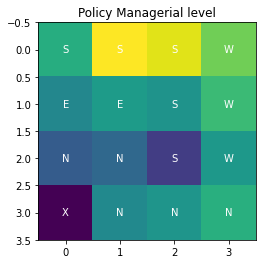

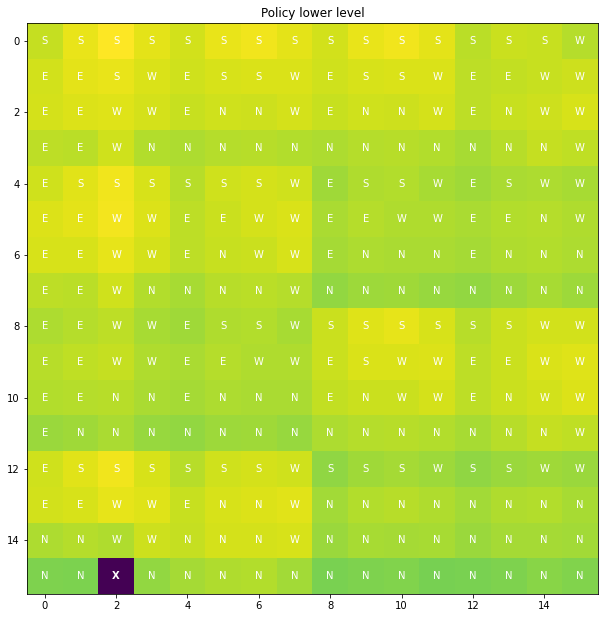

 90%|████████████████████████████████████████████████████████████████████▍       | 7201/8000 [1:25:35<16:05,  1.21s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 91%|████████████████████████████████████████████████████████████████████▉       | 7251/8000 [1:25:51<04:18,  2.90it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 91%|█████████████████████████████████████████████████████████████████████▎      | 7301/8000 [1:26:06<04:11,  2.78it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 92%|█████████████████████████████████████████████████████████████████████▊      | 7351/8000 [1:26:22<03:29,  3.10it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 93%|██████████████████████████████████████████████████████████████████████▎     | 7401/8000 [1:26:38<03:06,  3.21it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 93%|██████████████████████████████████████████████████████████████████████▊     | 7451/8000 [1:26:55<03:22,  2.71it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 94%|███████████████████████████████████████████████████████████████████████▎    | 7500/8000 [1:27:10<02:08,  3.89it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

[['S' 'S' 'S' 'W' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'W']
 ['E' 'E' 'W' 'W' 'E' 'S' 'S' 'W' 'E' 'S' 'S' 'W' 'E' 'E' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'W' 'W']
 ['E' 'E' 'W' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['S' 'S' 'S' 'S' 'S' 'S' 'S' 'W' 'E' 'S' 'S' 'W' 'S' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'S' 'W' 'W' 'E' 'E' 'W' 'W' 'E' 'E' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'N' 'W' 'W' 'E' 'N' 'N' 'W' 'E' 'N' 'W' 'W']
 ['E' 'W' 'W' 'N' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'W']
 ['E' 'E' 'W' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'S' 'W' 'W' 'E' 'S' 'W' 'W' 'E' 'E' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'N' 'W' 'W' 'E' 'N' 'W' 'W' 'E' 'N' 'W' 'W']
 ['E' 'N' 'N' 'N' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'W']
 ['E' 'E' 'W' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'S' 'W' 'S' 'S' 'W' 'W']
 ['E' 'E' 'W' 'W' 'E' 'N' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']
 ['N' 'N' 'N' 'W' 'N' 'N' 'N' 'W' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 

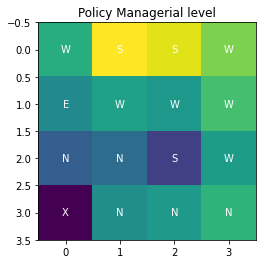

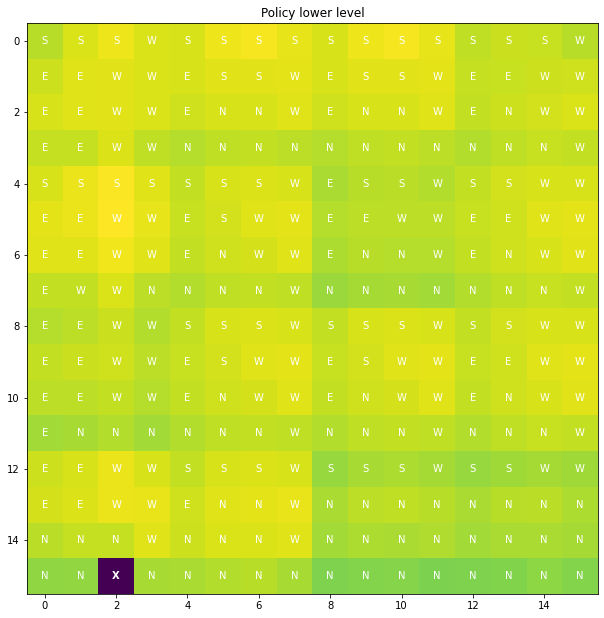

 94%|███████████████████████████████████████████████████████████████████████▎    | 7501/8000 [1:27:13<10:18,  1.24s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 94%|███████████████████████████████████████████████████████████████████████▋    | 7551/8000 [1:27:30<02:35,  2.90it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 95%|████████████████████████████████████████████████████████████████████████▏   | 7601/8000 [1:27:46<02:10,  3.06it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 96%|████████████████████████████████████████████████████████████████████████▋   | 7651/8000 [1:28:01<01:42,  3.39it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 96%|█████████████████████████████████████████████████████████████████████████▏  | 7701/8000 [1:28:18<01:33,  3.20it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 97%|█████████████████████████████████████████████████████████████████████████▋  | 7751/8000 [1:28:33<01:14,  3.32it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 98%|██████████████████████████████████████████████████████████████████████████  | 7800/8000 [1:28:48<00:52,  3.78it/s]

[['S' 'S' 'S' 'W']
 ['E' 'E' 'S' 'W']
 ['N' 'N' 'S' 'W']
 ['Search' 'N' 'N' 'N']]
[[list([(0, 1895.5223388671875), (1, 2389.877685546875), (2, 2321.688720703125), (3, 2342.723388671875)])
  list([(0, 2871.595947265625), (1, 3778.828857421875), (2, 3300.647705078125), (3, 3648.000732421875)])
  list([(0, 2708.788818359375), (1, 3605.33251953125), (2, 3072.520263671875), (3, 3526.419189453125)])
  list([(0, 2022.60205078125), (1, 2770.299560546875), (2, 2389.23779296875), (3, 3005.433349609375)])]
 [list([(0, 1670.3638916015625), (1, 1653.5169677734375), (2, 1810.754150390625), (3, 1344.923583984375)])
  list([(0, 2019.516357421875), (1, 2120.70361328125), (2, 2137.413818359375), (3, 2125.298095703125)])
  list([(0, 1570.9588623046875), (1, 2007.7982177734375), (2, 1741.24755859375), (3, 2004.4127197265625)])
  list([(0, 2053.360107421875), (1, 2221.8671875), (2, 2171.02197265625), (3, 2638.850341796875)])]
 [list([(0, 1149.00830078125), (1, 255.9259796142578), (2, 1005.24169921875), (3,

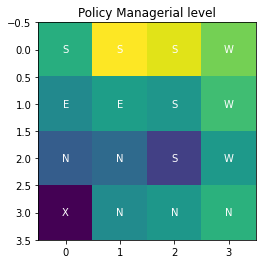

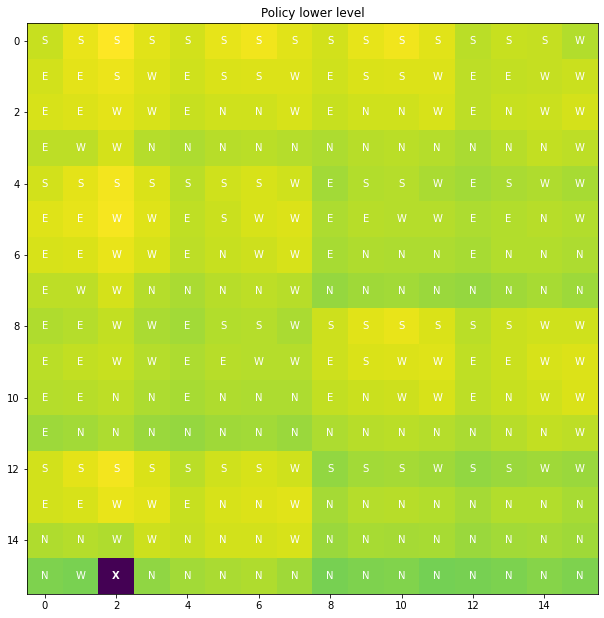

 98%|██████████████████████████████████████████████████████████████████████████  | 7801/8000 [1:28:51<03:55,  1.19s/it]

cccc
[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 15

 98%|██████████████████████████████████████████████████████████████████████████▌ | 7851/8000 [1:29:07<00:48,  3.04it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 99%|███████████████████████████████████████████████████████████████████████████ | 7901/8000 [1:29:23<00:34,  2.88it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

 99%|███████████████████████████████████████████████████████████████████████████▌| 7951/8000 [1:29:38<00:16,  2.96it/s]

[765, 441, 703, 470, 756, 259, 459, 811, 115, 231, 2714, 501, 370, 441, 352, 36, 1801, 466, 1291, 520, 63, 14, 2, 984, 692, 44, 72, 412, 232, 161, 95, 117, 95, 528, 299, 1067, 1, 383, 327, 185, 646, 9, 636, 182, 688, 378, 975, 270, 11, 102, 7, 32, 3, 520, 334, 8, 1876, 22, 567, 354, 462, 102, 341, 163, 216, 168, 137, 170, 84, 340, 152, 512, 196, 14, 153, 12, 502, 14, 281, 223, 719, 68, 38, 191, 121, 289, 52, 6, 126, 1476, 652, 383, 217, 294, 175, 422, 225, 104, 368, 156, 18, 1005, 811, 62, 268, 319, 36, 24, 518, 379, 518, 302, 53, 476, 404, 471, 133, 499, 580, 196, 164, 493, 157, 140, 149, 50, 128, 161, 72, 419, 320, 504, 58, 121, 307, 138, 92, 561, 39, 275, 433, 490, 30, 776, 356, 81, 383, 440, 204, 436, 172, 159, 153, 199, 161, 35, 549, 3, 226, 119, 1151, 156, 38, 162, 122, 26, 106, 185, 249, 314, 130, 50, 117, 676, 186, 16, 674, 180, 695, 423, 351, 221, 30, 251, 111, 203, 500, 531, 458, 612, 202, 1148, 6, 55, 786, 11, 134, 12, 381, 57, 858, 298, 116, 457, 9, 534, 74, 73, 25, 150, 18

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [1:29:54<00:00,  1.48it/s]


In [133]:

# results = {}
counter = 0
# length=7
# env = Hierarchical_Maze(16,2, 4, 2,True)
num_episodes =8000
batch_size = 1
discount_factor = 1
learn_rate = 1e-4
seed = 100  # This is not randomly chosen
random.seed(seed)
torch.manual_seed(seed)
r_dict_3={}

device = torch.device("cpu")

for length in [7]:
#     for num_hidden in  [int(n_input*1.1)]:
# counter=0
    n_input = 2*length ** 2 + 8

    for num_hidden in  [int(2*length ** 2)]:
#                         ,int(n_input*1.1),int(n_input*1.3),int(n_input*1.5),int(n_input*1.7),int(n_input*2)]:
#     for length in [3]:
        memory = ReplayMemory(1)



        Q_policy = QNetwork(env, n_input, num_hidden, device,length).to(device)
        Q_target = QNetwork(env, n_input, num_hidden, device,length).to(device)
        print(Q_policy.search_lims
             )
        # Q_policy = QNetwork(n_input, num_hidden, device).to(device)
        # Q_target = QNetwork(n_input, num_hidden, device).to(device)

        # policy_net = DQN(screen_height, screen_width, n_actions).to(device)
        # target_net = DQN(screen_height, screen_width, n_actions).to(device)
        Q_target.load_state_dict(Q_policy.state_dict())
        Q_target.eval()
        allowed_actions = env.possible_actions(Q_policy.expected_level, Q_policy.loc)

        policy = EpsilonGreedyPolicy(Q_policy, 0.08)

        episode_durations, losses, Visit_table,rewards,clch = run_episodes(train, Q_target, Q_policy, policy, memory, env, num_episodes,
                                                              batch_size,
                                                              discount_factor, learn_rate, np.minimum(500,num_episodes))
        r_dict_3[counter]={'num_hidden':num_hidden,'length':length,'Q_policy':copy.copy(Q_policy),'episode_durations':copy.copy(episode_durations),
                         'losses':copy.copy(losses),'rewards':copy.copy(rewards) }
        counter=counter+1
#         import matplotlib.pyplot as plt
#         pd.Series(episode_durations).rolling(100).mean().plot(label='HDQN rolling steps')






In [134]:
pd.Series(losses).rolling(1000).mean()

0                   NaN
1                   NaN
2                   NaN
3                   NaN
4                   NaN
              ...      
559741    324268.572978
559742    324239.396353
559743    324140.747177
559744    324139.235076
559745    325009.717959
Length: 559746, dtype: float64

<AxesSubplot:>

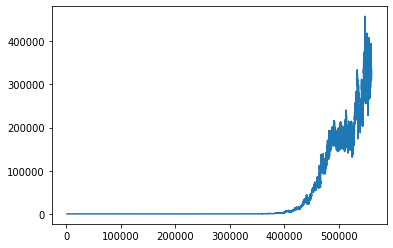

In [135]:
pd.Series(losses).rolling(1000).mean().plot()

In [136]:
Q_policy.man_layer.weight

Parameter containing:
tensor([[ 0.0194, -3.3273, -3.4153]], requires_grad=True)

In [137]:
Q_policy.man_layer.bias

Parameter containing:
tensor([-3.6060], requires_grad=True)

In [138]:
for i in range(3):
    x=torch.zeros(3)
    x[i]=1
#     ([0.,0.,1.]
    print(Q_policy.man_layer(x))


tensor([-3.5866], grad_fn=<AddBackward0>)
tensor([-6.9333], grad_fn=<AddBackward0>)
tensor([-7.0213], grad_fn=<AddBackward0>)


In [139]:
el=env.maze.shape[0]
ml=env.manager_view
nm=int(el/ml)

# {x:FlatQ.Q_table[1][x][4] for x in range(nm**2)}

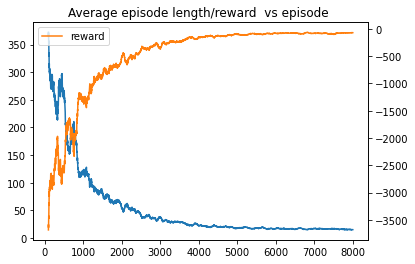

In [140]:

pd.Series(episode_durations).rolling(100).mean().plot(label='episode duration')
pd.Series(rewards).rolling(100).mean().plot(secondary_y=True,label='reward')
plt.title('Average episode length/reward  vs episode ')
plt.legend()

In [141]:
pd.Series(episode_durations).rolling(100).mean().min()

14.7

In [142]:
pd.Series(episode_durations).rolling(100).mean().idxmin()

7971

<AxesSubplot:>

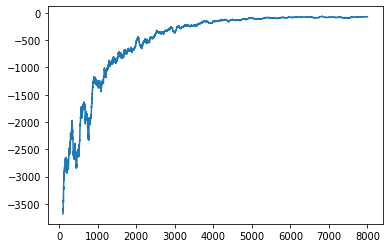

In [143]:
pd.Series(rewards).rolling(100).mean().plot()

In [144]:
pd.Series(rewards).rolling(100).mean().idxmax()

6826

In [145]:
pd.Series(rewards).rolling(100).mean().max()

-63.09

In [146]:
Q_policy

QNetwork(
  (l1): Linear(in_features=98, out_features=98, bias=True)
  (l2): Linear(in_features=98, out_features=98, bias=True)
  (task_layer): Linear(in_features=5, out_features=98, bias=True)
  (man_layer): Linear(in_features=3, out_features=1, bias=True)
  (l4): Linear(in_features=98, out_features=98, bias=True)
  (l3): Linear(in_features=98, out_features=5, bias=True)
  (conv_1): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1))
  (subsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [147]:
# policy_man_1

In [148]:
# man_values
nm=4
r_values={x:FlatQ.R_table[1][x][4] for x in range(nm**2)}
r_values

{0: {0: [], 1: [-2], 2: [-2], 3: [], 4: []},
 1: {0: [], 1: [-2], 2: [-2], 3: [-2], 4: []},
 2: {0: [], 1: [-2], 2: [-2], 3: [-2], 4: []},
 3: {0: [], 1: [-2], 2: [], 3: [-2], 4: []},
 4: {0: [-2], 1: [-2], 2: [-2], 3: [], 4: []},
 5: {0: [-2], 1: [-2], 2: [-2], 3: [-2], 4: []},
 6: {0: [-2], 1: [-2], 2: [-2], 3: [-2], 4: []},
 7: {0: [-2], 1: [-2], 2: [], 3: [-2], 4: []},
 8: {0: [-2], 1: [0], 2: [-2], 3: [], 4: []},
 9: {0: [-2], 1: [-2], 2: [-2], 3: [-2], 4: []},
 10: {0: [-2], 1: [-2], 2: [-2], 3: [-2], 4: []},
 11: {0: [-2], 1: [-2], 2: [], 3: [-2], 4: []},
 12: {0: [], 1: [], 2: [], 3: [], 4: []},
 13: {0: [-2], 1: [], 2: [-2], 3: [0], 4: []},
 14: {0: [-2], 1: [], 2: [-2], 3: [-2], 4: []},
 15: {0: [-2], 1: [], 2: [], 3: [-2], 4: []}}

In [156]:
el=16
nm=4
sm=[]
list_1=[]
for y1 in range(el):
    for y2 in range(el):
        mn=env.get_super_manager_1([y1,y2])[1]
        if mn not in sm:
            sm.append(mn)
            list_1.append([y1,y2])
        
man_values={x:FlatQ.Q_table[1][x][4] for x in range(nm**2)}
r_values={x:FlatQ.R_table[1][x][4] for x in range(nm**2)}

man_values_sq=[ np.max([          man_values[y][K]                     for K in man_values[y].keys() if K in env.possible_actions(1,l)])          for y,l in enumerate(list_1)]
# policy_man_1=[[x for x in man_values[y].keys() if  man_values[y][x]==np.max([y1 for y1 in man_values[y].values() if y1!=-1.11111])][0] for y in range(16)]
policy_man_1=[[x for x in man_values[y].keys() if man_values[y][x]==  np.max([          man_values[y][K]                     for K in man_values[y].keys() if K in env.possible_actions(1,l)])][0]          for y,l in enumerate(list_1)]
policy_man=[action_dict[x] for x in policy_man_1]


In [157]:
[env.possible_actions(1,l)[0] for l in list_1]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0]

In [158]:



# man_values_sq=[[x for x in man_values[y].values() if  x==np.max([y1 for y1 in man_values[y].values() if y
#                                                                  in env.possible_actions(1,l)])][0] for y,l in enumerate(list_1)]

agent_policy={}
agent_policy_1={}
agent_values={}
for y in FlatQ.Q_table[2].keys():
    locy=[int(y/el),int(y%el)]
    mang=env.get_super_manager_1(locy)[1]
    mang_n=int(mang[0]*nm+mang[1])
    task=policy_man_1[mang_n]
    allowed_actions=env.possible_actions(2,locy)
    if locy!=env.goal_init_state:
#         print(locy)

        action=[x for x in FlatQ.Q_table[2][y][task].keys() if FlatQ.Q_table[2][y][task][x]==np.max([FlatQ.Q_table[2][y][task][a] for a in allowed_actions])][0]
        value_a=[x for x in FlatQ.Q_table[2][y][task].values() if x==np.max([FlatQ.Q_table[2][y][task][a] for a in allowed_actions])][0]
        agent_policy[y]=action_dict[action]
        agent_policy_1[y]=action
        agent_values[y]=value_a
    else:
#         print('blah')
        agent_policy[y]='X'
        agent_policy_1[y]=0
        agent_values[y]=0
    






In [159]:
policy_man_1

[1, 3, 3, 2, 1, 3, 1, 1, 1, 3, 3, 3, 4, 3, 3, 3]

In [214]:
np.array([int(x*100)/100 for x in man_values_sq]).reshape(4,4)


array([[ -5.38,  -7.3 ,  -9.25, -11.24],
       [ -2.57,  -5.18,  -7.03,  -9.15],
       [ -0.13,  -2.58,  -5.32,  -7.23],
       [  0.  ,  -0.2 ,  -2.47,  -4.72]])

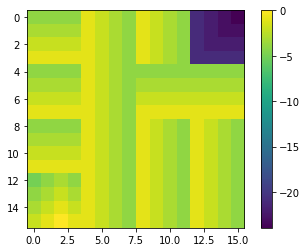

In [161]:
plt.imshow(np.array([x for x in agent_values.values()]).reshape(el,el))
plt.colorbar()

In [162]:
np.array([x for x in agent_values.values()]).reshape(el,el)


array([[ -3.99999666,  -3.99999988,  -4.        ,  -4.        ,
         -1.        ,  -2.        ,  -3.        ,  -4.        ,
         -1.        ,  -2.        ,  -3.        ,  -4.        ,
        -21.        , -21.99999998, -22.99975477, -23.9440047 ],
       [ -3.        ,  -3.        ,  -3.        ,  -3.        ,
         -1.        ,  -2.        ,  -3.        ,  -4.        ,
         -1.        ,  -2.        ,  -3.        ,  -4.        ,
        -21.        , -21.9999989 , -22.98922589, -22.99997197],
       [ -2.        ,  -2.        ,  -2.        ,  -2.        ,
         -1.        ,  -2.        ,  -3.        ,  -4.        ,
         -1.        ,  -2.        ,  -3.        ,  -4.        ,
        -21.        , -21.99910853, -21.99999551, -21.99999992],
       [ -1.        ,  -1.        ,  -1.        ,  -1.        ,
         -1.        ,  -2.        ,  -3.        ,  -4.        ,
         -1.        ,  -2.        ,  -3.        ,  -4.        ,
        -21.        , -21.        , -

In [163]:
# np.array([x for x in agent_values.values()]).reshape(el,el)
#

policy_man_1

[1, 3, 3, 2, 1, 3, 1, 1, 1, 3, 3, 3, 4, 3, 3, 3]

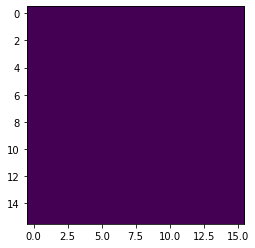

In [164]:
plt.imshow(env.maze)

In [165]:
np.array([x for x in agent_policy.values()]).reshape(el,el)


array([['S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
        'W', 'W', 'S'],
       ['S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
        'W', 'S', 'S'],
       ['S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
        'S', 'S', 'S'],
       ['S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'S',
        'S', 'S', 'S'],
       ['S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'S', 'S', 'S', 'S', 'S',
        'S', 'S', 'S'],
       ['S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'S', 'S', 'S', 'S', 'S',
        'S', 'S', 'S'],
       ['S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'S', 'S', 'S', 'S', 'S',
        'S', 'S', 'S'],
       ['S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'S', 'S', 'S', 'S', 'S',
        'S', 'S', 'S'],
       ['S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
        'W', 'W', 'W'],
       ['S', 'S', 'S', 'S', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W',
        'W', 'W', 'W'],
       ['S', 'S', 'S', 'S', 'W

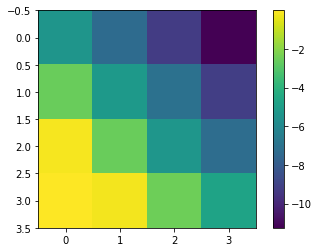

In [166]:
plt.imshow(np.array(man_values_sq).reshape(nm,nm))
plt.colorbar()


In [167]:
np.array(man_values_sq).reshape(nm,nm)


array([[-5.38951654e+00, -7.30604370e+00, -9.25016909e+00,
        -1.12490830e+01],
       [-2.57588091e+00, -5.18368020e+00, -7.03861988e+00,
        -9.15992831e+00],
       [-1.39821031e-01, -2.58663527e+00, -5.32179547e+00,
        -7.23277880e+00],
       [-4.88682771e-03, -2.02512708e-01, -2.47376670e+00,
        -4.72678795e+00]])

In [168]:
np.array(policy_man).reshape(nm,nm)

array([['S', 'W', 'W', 'E'],
       ['S', 'W', 'S', 'S'],
       ['S', 'W', 'W', 'W'],
       ['Search', 'W', 'W', 'W']], dtype='<U6')

In [169]:
rewards_v={}
rewards_h={}
for s in range(int(env.maze.shape[0]**2)):
#     print(s)
    d=False
    rewards_v[s]=0
    rewards_h[s]=0
    
    z=[int(s/env.maze.shape[0]),s%env.maze.shape[0]]
    if z!=env.goal_init_state:
    
        env.reset(agent_loc=z)
        Q_policy.reset(env)
    #     Q_policy.current_level=0
        agent_row = copy.copy(env.maze)
        step_counter = 0
    #     rewards_h=[]
    #     rewards=[]

        back_up_level=False
        r2=0
        r_h=0
        print("==================================================")
        print('State,',s)
        print("==================================================")

        while (d != True) or (back_up_level!=True) :
    #         while :
                moved_from_goal = False
                level2 = copy.copy(Q_policy.current_level)
                state_1 = copy.copy(Q_policy.loc)
                current_loc = copy.copy(Q_policy.loc)
                current_level = copy.copy(Q_policy.current_level)
                allowed_actions = env.possible_actions(current_level, current_loc)
                state = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers+1+5)
                state[:env.maze.shape[0] ** 2] = env.maze.flatten()
                loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
                loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
                if current_level == 0:
                    loc_idx2 = 0
                elif current_level != env.n_layers:
                    loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc], env, current_level)
                state[loc_idx2 + env.maze.shape[0] ** 2] = 1
                man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
                state[man_idx] = 1
                cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                if current_level != 0:
                    task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                    ttt = Q_policy.hierarchy_actions[current_level - 1]
                else:
                    task_idx = cc + 4
                    ttt = 4
                state[task_idx] = 1
                if level2 == env.n_layers:
                    old_step_counter = step_counter
                    step_counter = step_counter + 1
                if current_level == 0:

                    a = 4
                elif current_level==1:
                    s1=env.get_super_manager_1(Q_policy.loc)[1]
                    s11=int(s1[0]*4+s1[1])
                    a=policy_man_1[s11]
                else:
                    a=agent_policy_1[loc_idx2]
                if current_level == env.n_layers:
                    Visit_table[current_level][loc_idx2][ttt][a] += 1
                elif current_level == env.n_layers - 1:
                    loc_level = int(current_loc[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(current_loc[1] / env.manager_view)
                    Visit_table[current_level][loc_level][ttt][a] += 1
                ns, d = env.step(a, current_level, Q_policy)

                nl = copy.copy(Q_policy.current_level)
                Q_policy.loc = copy.copy(ns)
                statef = env.get_super_manager_1(ns)[1]
                if statef != env.get_super_manager_1(env.goal_init_state)[1]:
                    if Q_policy.hierarchy_actions[1] == 4:
                        moved_from_goal=True

                current_managers=env.get_super_manager_1(state_1)[Q_policy.current_level-1]
                new_managers=env.get_super_manager_1(ns)  [Q_policy.current_level-1]  
    #             print('cm,nm',current_managers,new_managers)
    #             print(step_counter)
    #             print(ns)
                if step_counter > 0:
                    if Q_policy.current_level != 0:
    #                     print(ns)
    #                     if ns==[5, 5]:
    #                         break
                        #                     print('checking if level should change')
                        env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy,moved_from_goal)
                    else:
                        Q_policy.expected_level = copy.copy(Q_policy.current_level)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
                old_reset = copy.copy(env.reset_reward)
                r = env.reward(Q_policy, d, current_level)
                r2=r2+r[-1]
                if current_level==2:
                    r_h=r_h-1
                cms=env.get_super_manager_1(Q_policy.loc)
                print("state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb")
                print(current_loc,a,ns,r,r2,d,r_h,current_level,Q_policy.current_tasks_loc,cms,env.reset_reward,Q_policy.tasks_bools)

                if d == True:
                    env.reset_reward = [5 for x in env.reset_reward]

                n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2  +env.n_layers+1+5)
                #             if current_level == env.n_layers:
                n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
                loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
                if Q_policy.expected_level == 0:
                    loc_idx2 = 0
                elif Q_policy.expected_level != env.n_layers:
                    loc_idx2 = int(ns[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(ns[1] / env.manager_view)
                n_agent_row[int(env.maze.shape[0] ** 2 + loc_idx2)] = 1
                man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
                n_agent_row[man_idx] = 1
                if nl != 0:
                    task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
                else:
                    task_idx = cc + 4
                n_agent_row[task_idx] = 1
                state = n_agent_row
                if Q_policy.current_level>copy.copy(Q_policy.expected_level):
                    back_up_level=True

                Q_policy.current_level = copy.copy(Q_policy.expected_level)
                if d != True:
                    env.reset_rewards_after_learning(old_reset)
                print("==================================================")
                print('backup',back_up_level)
                print("==================================================")

                if d or (back_up_level==True) :
            #                 print('done')
                    clch.append(copy.copy(env.count_level_change))

                    episode_durations.append(step_counter)
                    rewards_v[s]=r2
                    rewards_h[s]=r_h
    #                 d=True
                    break



State, 0
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 4 [0, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [0, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 1 [2, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup F

State, 6
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 4 [0, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 3 [0, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 3 [0, 5] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 3 [0, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 4] 3 [0, 3] [0, -2, -1] -3 False -3 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup T

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -21] -23 False -3 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
State, 15
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 4 [0, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 2 [0, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 1 [1, 15] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 15] 1 [2, 15] [0, -2, -1] -2 False -2 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 4] 3 [1, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 4] 3 [1, 3] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 21
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 4 [1, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 3 [1, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 5] 3 [1, 4] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 8] 3 [1, 7] [0, -2, -1] -3 False -3 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 27
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 11] 4 [1, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 11] 3 [1, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 11] 3 [1, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 10] 3 [1, 9] [0, -2, -1] -2 False -2 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0,

[2, 0] 1 [3, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 0] 1 [4, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 33
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 1] 4 [2, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 1] 1 [2, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 1] 1 [3, 1] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,rese

[2, 10] 3 [2, 9] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 9] 3 [2, 8] [0, -2, -1] -2 False -2 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 3 [2, 7] [0, -2, -1] -3 False -3 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 43
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 11] 4 [2, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 11] 3 [2, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [4, 3] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 52
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 4 [3, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 3 [3, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 3 [3, 3] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 53
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 5] 4 [3, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 10] 3 [3, 9] [0, -2, -1] -1 False -1 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 9] 3 [3, 8] [0, -2, -1] -2 False -2 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 8] 3 [3, 7] [0, -2, -1] -3 False -3 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 59
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 11] 4 [3, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 11] 3 [3, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 1 [4, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 1 [5, 1] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 1 [6, 1] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 1 [7, 1] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 1] 1 [8, 1] [0, -2, -1] -4 False -4 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State

[4, 6] 3 [4, 5] [0, -2, -1] -1 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 5] 3 [4, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 4] 3 [4, 3] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 71
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 7] 4 [4, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 7] 3 [4, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,rese

[5, 12] 1 [6, 12] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 12] 1 [7, 12] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 12] 1 [8, 12] [0, -2, -1] -4 False -4 2 [[0, 0], [2, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup True
State, 77
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 13] 4 [4, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 13] 1 [4, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,curren

[6, 1] 1 [7, 1] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 1] 1 [8, 1] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 82
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 4 [5, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 1 [5, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 1 [6, 2] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,rese

[5, 6] 3 [5, 5] [0, -2, -1] -2 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 5] 3 [5, 4] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 4] 3 [5, 3] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 88
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 8] 4 [5, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 8] 1 [5, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,rese

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 12] 1 [8, 12] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup True
State, 93
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 13] 4 [5, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 13] 1 [5, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 13] 1 [6, 13] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 13] 1 [7, 13] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0,

[6, 2] 1 [6, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 1 [7, 2] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 2] 1 [8, 2] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 99
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 4 [6, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [6, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb

State, 106
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 4 [6, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 1 [6, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 10] 1 [7, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 10] 1 [8, 10] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
State, 107
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 11] 4 [6, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 

State, 113
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 1] 4 [7, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 1] 1 [7, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 1] 1 [8, 1] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 114
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 2] 4 [7, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 2] 1 [7, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]


backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 5] 3 [7, 4] [0, -2, -1] -3 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 4] 3 [7, 3] [0, -2, -1] -4 False -4 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 120
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 4 [7, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 1 [7, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 1 [8, 8] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1

State, 128
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 4 [8, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 1 [8, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 1 [9, 0] [0, -2, -1] -1 False -1 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 1 [10, 0] [0, -2, -1] -2 False -2 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 1 [11, 0] [0, -2, -1] -3 False -3 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
bac

[8, 4] 3 [8, 3] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 133
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 4 [8, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8, 4] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 3 [8, 3] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 134
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

[8, 14] 3 [8, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 3 [8, 13] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 13] 3 [8, 12] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 3 [8, 11] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
State, 143
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 4 [8, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

[9, 7] 4 [9, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 3 [9, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 7] 3 [9, 6] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 6] 3 [9, 5] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 5] 3 [9, 4] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 

[9, 13] 4 [9, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 13] 3 [9, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 13] 3 [9, 12] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 3 [9, 11] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
State, 158
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 14] 4 [9, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

backup True
State, 165
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 4 [10, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 3 [10, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 3 [10, 4] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 3 [10, 3] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 166
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 6] 4 [10, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0

[11, 1] 4 [11, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 1] 1 [11, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 1] 1 [12, 1] [0, 0, -1] -1 False -1 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 178
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 4 [11, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 1 [11, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_ma

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 3 [11, 8] [0, -2, -1] -2 False -2 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 8] 3 [11, 7] [0, -2, -1] -3 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 187
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 4 [11, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.

[15, 0] 2 [15, 1] [0, 0, -1] -4 False -4 2 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 1] 2 [15, 2] [0, 0, -1] -5 True -5 2 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [5, 5, 5] [1. 1.]
backup False
State, 193
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 1] 4 [12, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 1] 4 [12, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 1] 1 [13, 1] [0, 0, -1] -1 False -1 2 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,curren

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 3 [12, 5] [0, -2, -1] -1 False -1 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 3 [12, 4] [0, -2, -1] -2 False -2 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 4] 3 [12, 3] [0, 0, -1] -3 False -3 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 199
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 7] 4 [12, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 7] 3 [12, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0,

backup True
State, 204
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 12] 4 [12, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 12] 3 [12, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 12] 3 [12, 11] [0, -2, -1] -1 False -1 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
State, 205
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 4 [12, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 3 [12, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0]

[13, 3] 4 [13, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 4 [13, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 3] 1 [14, 3] [0, 0, -1] -1 False -1 2 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 3] 1 [15, 3] [0, 0, -1] -2 False -2 2 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 3 [15, 2] [0, 0, -1] -3 True -3 2 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [5, 5, 5] [1. 1.]
backup False
State, 212
state,action,new_state,reward,done,step,current_level,curren

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 9] 3 [13, 8] [0, -2, -1] -1 False -1 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 8] 3 [13, 7] [0, -2, -1] -2 False -2 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 218
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 10] 4 [13, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 10] 3 [13, 10] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 10] 3 [13, 9] [0, -2, -1] -1 False -1 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] 

[14, 2] 4 [14, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 2] 1 [15, 2] [0, 0, -1] -1 True -1 2 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [5, 5, 5] [1. 1.]
backup False
State, 227
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 3] 4 [14, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 3] 4 [14, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 3] 1 [15, 3] [0, 0, -1] -1 False -1 2 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_T

[14, 9] 3 [14, 8] [0, -2, -1] -2 False -2 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 8] 3 [14, 7] [0, -2, -1] -3 False -3 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 235
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 11] 4 [14, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 11] 3 [14, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 11] 3 [14, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks

[15, 3] 4 [15, 3] [0, 0, 0] 0 False 0 1 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 3] 3 [15, 2] [0, 0, -1] -1 True -1 2 [[0, 0], [3.0, 0.0]] [[0, 0], [3.0, 0.0]] [5, 5, 5] [1. 1.]
backup False
State, 244
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 4] 4 [15, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 4] 3 [15, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 4] 3 [15, 3] [0, 0, -1] -1 False -1 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 245
state,action,new_state,reward,done,step,current_level,current

[15, 8] 3 [15, 7] [0, -2, -1] -3 False -3 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
State, 251
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 4 [15, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 3 [15, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 11] 3 [15, 10] [0, -2, -1] -1 False -1 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 10] 3 [15, 9] [0, -2, -1] -2 False -2 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Task

In [170]:
# step_counter

In [183]:
int(env.maze.shape[0]**2)%16

0

In [215]:
# rewards_v={}
rewards_h={}
for s in range(int(env.maze.shape[0]**2)):
#     print(s)
    d=False
#     rewards_v[s]=0
    rewards_h[s]=0
    
    z=[int(s/env.maze.shape[0]),s%env.maze.shape[0]]
    if z!=env.goal_init_state:
    
        env.reset(agent_loc=z)
        Q_policy.reset(env)
    #     Q_policy.current_level=0
        agent_row = copy.copy(env.maze)
        step_counter = 0
    #     rewards_h=[]
    #     rewards=[]

        back_up_level=False
        r2=0
        r_h=0
        print("==================================================")
        print('State,',s)
        print("==================================================")

        while d != True or (env.get_super_manager_1(Q_policy.loc)[1]!=env.get_super_manager_1(env.goal_init_state)[1]) :
    #         while :
                moved_from_goal = False
                level2 = copy.copy(Q_policy.current_level)
                state_1 = copy.copy(Q_policy.loc)
                current_loc = copy.copy(Q_policy.loc)
                current_level = copy.copy(Q_policy.current_level)
                allowed_actions = env.possible_actions(current_level, current_loc)
                state = np.zeros(2 * env.maze.shape[0] ** 2 + +env.n_layers+1+5)
                state[:env.maze.shape[0] ** 2] = env.maze.flatten()
                loc_idx = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
                loc_idx2 = int(env.maze.shape[0] * current_loc[0] + current_loc[1])
                if current_level == 0:
                    loc_idx2 = 0
                elif current_level != env.n_layers:
                    loc_idx2, locs = Q_policy.get_subs([int(x / env.manager_view) for x in current_loc], env, current_level)
                state[loc_idx2 + env.maze.shape[0] ** 2] = 1
                man_idx = int(current_level + 2 * env.maze.shape[0] ** 2)
                state[man_idx] = 1
                cc = 2 * env.maze.shape[0] ** 2 + env.n_layers + 1
                if current_level != 0:
                    task_idx = cc + Q_policy.hierarchy_actions[current_level - 1]
                    ttt = Q_policy.hierarchy_actions[current_level - 1]
                else:
                    task_idx = cc + 4
                    ttt = 4
                state[task_idx] = 1
                if level2 == env.n_layers:
                    old_step_counter = step_counter
                    step_counter = step_counter + 1
                if current_level == 0:

                    a = 4
                elif current_level==1:
                    s1=env.get_super_manager_1(Q_policy.loc)[1]
                    s11=int(s1[0]*4+s1[1])
                    a=policy_man_1[s11]
                else:
                    a=agent_policy_1[loc_idx2]
                if current_level == env.n_layers:
                    Visit_table[current_level][loc_idx2][ttt][a] += 1
                elif current_level == env.n_layers - 1:
                    loc_level = int(current_loc[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(current_loc[1] / env.manager_view)
                    Visit_table[current_level][loc_level][ttt][a] += 1
                ns, d = env.step(a, current_level, Q_policy)

                nl = copy.copy(Q_policy.current_level)
                Q_policy.loc = copy.copy(ns)
                statef = env.get_super_manager_1(ns)[1]
                if statef != env.get_super_manager_1(env.goal_init_state)[1]:
                    if Q_policy.hierarchy_actions[1] == 4:
                        moved_from_goal=True

                current_managers=env.get_super_manager_1(state_1)[Q_policy.current_level-1]
                new_managers=env.get_super_manager_1(ns)  [Q_policy.current_level-1]  
    #             print('cm,nm',current_managers,new_managers)
    #             print(step_counter)
    #             print(ns)
                if step_counter > 0:
                    if Q_policy.current_level != 0:
    #                     print(ns)
    #                     if ns==[5, 5]:
    #                         break
                        #                     print('checking if level should change')
                        env.checks_if_level_should_change(state_1, ns, Q_policy.current_level, d, Q_policy,moved_from_goal)
                    else:
                        Q_policy.expected_level = copy.copy(Q_policy.current_level)
                else:
                    Q_policy.expected_level = copy.copy(Q_policy.current_level)
                old_reset = copy.copy(env.reset_reward)
                r = env.reward(Q_policy, d, current_level)
#                 r2=r2+r[-1]
                if current_level==2:
                    reward_dict = env.get_reward_dict()
                    if env.maze[ns[0],ns[1]]==1:
                        r_h=r_h+reward_dict['Wall']
                    else:
                        r_h=r_h+reward_dict['SearchLimit']
                cms=env.get_super_manager_1(Q_policy.loc)
                print("state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb")
                print(current_loc,a,ns,r,r2,d,r_h,current_level,Q_policy.current_tasks_loc,cms,env.reset_reward,Q_policy.tasks_bools)

                if d == True:
                    env.reset_reward = [5 for x in env.reset_reward]

                n_agent_row = np.zeros(2 * env.maze.shape[0] ** 2  +env.n_layers+1+5)
                #             if current_level == env.n_layers:
                n_agent_row[:env.maze.shape[0] ** 2] = env.maze.flatten()
                loc_idx = int(env.maze.shape[0] * ns[0] + ns[1])
                loc_idx2 = int(env.maze.shape[0] * ns[0] + ns[1])
                if Q_policy.expected_level == 0:
                    loc_idx2 = 0
                elif Q_policy.expected_level != env.n_layers:
                    loc_idx2 = int(ns[0] / env.manager_view) * env.maze.shape[0]/env.manager_view + int(ns[1] / env.manager_view)
                n_agent_row[int(env.maze.shape[0] ** 2 + loc_idx2)] = 1
                man_idx = int(Q_policy.expected_level + 2 * env.maze.shape[0] ** 2)
                n_agent_row[man_idx] = 1
                if nl != 0:
                    task_idx = cc + Q_policy.hierarchy_actions[Q_policy.expected_level - 1]
                else:
                    task_idx = cc + 4
                n_agent_row[task_idx] = 1
                state = n_agent_row
                if Q_policy.current_level>copy.copy(Q_policy.expected_level):
                    back_up_level=True

                Q_policy.current_level = copy.copy(Q_policy.expected_level)
                if d != True:
                    env.reset_rewards_after_learning(old_reset)
                print("==================================================")
                print('backup',back_up_level)
                print("==================================================")
                if r_h<-env.maze.shape[0]*2:
                    d=True
                if d or (env.get_super_manager_1(ns)[1]==env.get_super_manager_1(env.goal_init_state)[1]) :
            #                 print('done')
                    clch.append(copy.copy(env.count_level_change))

                    episode_durations.append(step_counter)
#                     rewards_v[s]=r2
                    rewards_h[s]=r_h
    #                 d=True
                    break



State, 0
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 4 [0, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [0, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 0] 1 [1, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 0] 1 [2, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 0] 1 [3, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup Fals

[10, 1] 1 [11, 1] [0, -2, -1] 0 False -11 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 1] 1 [12, 1] [0, 0, -1] 0 False -12 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 2
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 2] 4 [0, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 2] 1 [0, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 2] 1 [1, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,rese

[8, 3] 1 [8, 3] [0, 0, 0] 0 False -8 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9, 3] [0, -2, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10, 3] [0, -2, -1] 0 False -10 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -12 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 4
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 4] 3 [0, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 3] 1 [0, 3] [0, 0, 0] 0 False -3 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 3] 1 [1, 3] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 3] 1 [2, 3] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 3] 1 [3, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup True

[0, 8] 3 [0, 7] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 7] 3 [0, 7] [0, 0, 0] 0 False -1 1 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 7] 3 [0, 6] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 6] 3 [0, 5] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 5] 3 [0, 4] [0, -2, -1] 0 False -4 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 4] 3 [0,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [4, 3] [0, 0, 0] 0 False -10 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [5, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 1 [6, 3] [0, -2, -1] 0 False -12 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [7, 3] [0, -2, -1] 0 False -13 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 1 [8, 3] [0, -2, -1] 0 False -14 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,a

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -18 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -19 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 11
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 4 [0, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 3 [0, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 3 [0, 10] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
b

[0, 12] 2 [0, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -21] 0 False -1 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 3 [0, 11] [0, 0, 0] 0 False -1 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 3 [0, 10] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 10] 3 [0, 9] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 

[0, 13] 4 [0, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 13] 2 [0, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 13] 3 [0, 12] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -21] 0 False -2 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 11] 3 [0, 11] [0, 0, 0] 0 False -2 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb


state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 4 [0, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 2 [0, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 14] 3 [0, 13] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 13] 3 [0, 12] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 12] 3 [0, 11] [0, -2, -21] 0 False -3 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup Tr

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[0, 15] 1 [1, 15] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 15] 1 [2, 15] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 15] 1 [3, 15] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 15] 1 [4, 15] [0, -2, -21] 0 False -4 2 [[0, 0], [0, 4]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 15] 1 [4, 15] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup Tru

[3, 0] 1 [4, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 1 [4, 0] [0, 0, 0] 0 False -3 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 0] 1 [5, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 0] 1 [6, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 0] 1 [7, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 0] 1 [8,

[4, 2] 1 [5, 2] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 1 [6, 2] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 1 [7, 2] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 2] 1 [8, 2] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 1 [8, 2] [0, 0, 0] 0 False -7 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 2] 1 [9,

[3, 3] 1 [4, 3] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [4, 3] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [5, 3] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 1 [6, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [7, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 1 [8,

[4, 3] 1 [5, 3] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 1 [6, 3] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [7, 3] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 1 [8, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -11 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -15 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -16 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 25
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 9] 4 [1, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 9] 3 [1, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 9] 3 [1, 8] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup 

[3, 3] 1 [4, 3] [0, -2, -1] 0 False -10 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [4, 3] [0, 0, 0] 0 False -10 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [5, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 1 [6, 3] [0, -2, -1] 0 False -12 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [7, 3] [0, -2, -1] 0 False -13 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 

[4, 3] 1 [5, 3] [0, -2, -1] 0 False -12 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 1 [6, 3] [0, -2, -1] 0 False -13 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [7, 3] [0, -2, -1] 0 False -14 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 1 [8, 3] [0, -2, -1] 0 False -15 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -15 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -20 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 29
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 13] 4 [1, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 13] 2 [1, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 13] 3 [1, 12] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1, 12] 3 [1, 11] [0, -2, -21] 0 False -2 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 2.0]] [0, 0,

[3, 14] 1 [4, 14] [0, -2, -21] 0 False -3 2 [[0, 0], [0, 4]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 1 [4, 14] [0, 0, 0] 0 False -3 1 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 1 [5, 14] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 14] 1 [6, 14] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 1 [7, 14] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[

[8, 14] 3 [8, 13] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 13] 3 [8, 12] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 3 [8, 11] [0, -2, -1] 0 False -11 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 3 [8, 11] [0, 0, 0] 0 False -11 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 3 [8, 10] [0, -2, -1] 0 False -12 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,t

[2, 1] 1 [3, 1] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 1] 1 [4, 1] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 1 [4, 1] [0, 0, 0] 0 False -2 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 1 [5, 1] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 1] 1 [6, 1] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 1] 1 [7

[9, 3] 1 [10, 3] [0, -2, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -10 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 36
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 4 [2, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 3 [2, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,rese

[8, 3] 1 [9, 3] [0, -2, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10, 3] [0, -2, -1] 0 False -10 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -12 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 38
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 6] 4 [2, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 1.0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 3 [2, 3] [0, -2, -1] 0 False -4 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 3] 1 [2, 3] [0, 0, 0] 0 False -4 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 3] 1 [3, 3] [0, -2, -1] 0 False -5 2 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [4, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [4, 3] [0, 0, 0] 0 False -6 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,n

State, 41
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 9] 4 [2, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 2.0]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 9] 3 [2, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 9] 3 [2, 8] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 8] 3 [2, 7] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 1]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 7] 3 [2, 7] [0, 0, 0] 0 False -2 1 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
s

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 7] 3 [2, 6] [0, -2, -1] 0 False -4 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 6] 3 [2, 5] [0, -2, -1] 0 False -5 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 5] 3 [2, 4] [0, -2, -1] 0 False -6 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 4] 3 [2, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 3] 1 [2, 3] [0, 0, 0] 0 False -7 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [4, 3] [0, 0, 0] 0 False -10 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [5, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 1 [6, 3] [0, -2, -1] 0 False -12 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [7, 3] [0, -2, -1] 0 False -13 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 1 [8, 3] [0, -2, -1] 0 False -14 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup 

[4, 3] 1 [5, 3] [0, -2, -1] 0 False -12 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 1 [6, 3] [0, -2, -1] 0 False -13 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [7, 3] [0, -2, -1] 0 False -14 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 1 [8, 3] [0, -2, -1] 0 False -15 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -15 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -19 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -20 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 46
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 14] 4 [2, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 14] 2 [2, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 14] 1 [3, 14] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
b

[9, 3] 1 [10, 3] [0, -2, -1] 0 False -19 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -20 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -21 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 47
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 15] 4 [2, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[2, 15] 2 [2, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_ma

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9, 3] [0, -2, -1] 0 False -19 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10, 3] [0, -2, -1] 0 False -20 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -21 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -22 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 48
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 0] 4 [3, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0]

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 1] 1 [11, 1] [0, -2, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 1] 1 [12, 1] [0, 0, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 50
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 2] 4 [3, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 0.0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 2] 1 [3, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 2] 1 [4, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 3 [3, 3] [0, -2, -1] 0 False -1 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [3, 3] [0, 0, 0] 0 False -1 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [4, 3] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [4, 3] [0, 0, 0] 0 False -2 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [5, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
s

[3, 4] 3 [3, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [3, 3] [0, 0, 0] 0 False -3 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [4, 3] [0, -2, -1] 0 False -4 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [4, 3] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 3] 1 [5, 3] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 3] 1 [6, 3

[3, 7] 3 [3, 6] [0, -2, -1] 0 False -2 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 6] 3 [3, 5] [0, -2, -1] 0 False -3 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 5] 3 [3, 4] [0, -2, -1] 0 False -4 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 4] 3 [3, 3] [0, -2, -1] 0 False -5 2 [[0, 0], [0, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [3, 3] [0, 0, 0] 0 False -5 1 [[0, 0], [1, 0]] [[0, 0], [0.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 3] 1 [4,

[7, 3] 1 [8, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -11 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9, 3] [0, -2, -1] 0 False -12 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10, 3] [0, -2, -1] 0 False -13 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -14 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11,

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 3 [8, 5] [0, -2, -1] 0 False -12 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8, 4] [0, -2, -1] 0 False -13 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 3 [8, 3] [0, -2, -1] 0 False -14 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -14 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9, 3] [0, -2, -1] 0 False -15 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup 

State, 62
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 14] 4 [3, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 14] 2 [3, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 14] 1 [4, 14] [0, -2, -21] 0 False -1 2 [[0, 0], [0, 4]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 1 [4, 14] [0, 0, 0] 0 False -1 1 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 1 [5, 14] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
bac

State, 63
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 15] 4 [3, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [0.0, 3.0]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 15] 2 [3, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [0, 4]] [[0, 0], [0.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[3, 15] 1 [4, 15] [0, -2, -21] 0 False -1 2 [[0, 0], [0, 4]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 15] 1 [4, 15] [0, 0, 0] 0 False -1 1 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 15] 1 [5, 15] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
bac

[8, 0] 1 [9, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 1 [10, 0] [0, -2, -1] 0 False -6 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 1 [11, 0] [0, -2, -1] 0 False -7 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 1 [12, 0] [0, 0, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 65
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 1] 4 [4, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,res

[9, 3] 1 [10, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 68
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 4] 4 [4, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 4] 3 [4, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset

State, 70
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 6] 4 [4, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 6] 3 [4, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 6] 3 [4, 5] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 5] 3 [4, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 4] 3 [4, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup Tru

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10, 3] [0, -2, -1] 0 False -10 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -12 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 72
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 4 [4, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 8] 1 [4, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup

[8, 7] 3 [8, 6] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 3 [8, 5] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8, 4] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 3 [8, 3] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -10 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [

[8, 11] 3 [8, 10] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 3 [8, 9] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 3 [8, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 7] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 7] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 

[8, 7] 3 [8, 6] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 3 [8, 5] [0, -2, -1] 0 False -11 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8, 4] [0, -2, -1] 0 False -12 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 3 [8, 3] [0, -2, -1] 0 False -13 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -13 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 

[4, 14] 1 [4, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[4, 14] 1 [5, 14] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 14] 1 [6, 14] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 1 [7, 14] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 14] 1 [8, 14] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 13] 3 [8, 12] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 3 [8, 11] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 3 [8, 11] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 3 [8, 10] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 3 [8, 9] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
st

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 1] 1 [12, 1] [0, 0, -1] 0 False -7 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 82
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 4 [5, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 0.0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 1 [5, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 2] 1 [6, 2] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 2] 1 [7, 2] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.

[5, 3] 1 [6, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [7, 3] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 1 [8, 3] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -5 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10

[5, 8] 4 [5, 8] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 2.0]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 8] 1 [5, 8] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 8] 1 [6, 8] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 8] 1 [7, 8] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 2]] [[0, 0], [1.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 8] 1 [8, 8] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3

[8, 6] 3 [8, 5] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8, 4] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 3 [8, 3] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -10 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 

[8, 10] 3 [8, 9] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 3 [8, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 7] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 7] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 6] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 3 [8

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -17 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 94
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 14] 4 [5, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 14] 1 [5, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[5, 14] 1 [6, 14] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 1 [7, 14] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
b

[5, 15] 1 [6, 15] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 15] 1 [7, 15] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 15] 1 [8, 15] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 3 [8, 15] [0, 0, 0] 0 False -3 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 15] 3 [8, 14] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb


[8, 0] 1 [8, 0] [0, 0, 0] 0 False -2 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 0] 1 [9, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 1 [10, 0] [0, -2, -1] 0 False -4 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 1 [11, 0] [0, -2, -1] 0 False -5 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 1 [12, 0] [0, 0, -1] 0 False -6 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 97
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,t

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 4] 4 [6, 4] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 4] 3 [6, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 4] 3 [6, 3] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [6, 3] [0, 0, 0] 0 False -1 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [7, 3] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action

[6, 4] 3 [6, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [6, 3] [0, 0, 0] 0 False -3 1 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 3] 1 [7, 3] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 1 [8, 3] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -5 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9, 3

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 8] [0, 0, 0] 0 False -2 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 7] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 7] [0, 0, 0] 0 False -3 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 6] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 3 [8, 5] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,n

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 3 [8, 9] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 3 [8, 8] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 7] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 7] [0, 0, 0] 0 False -5 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 6] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True

[8, 12] 3 [8, 12] [0, 0, 0] 0 False -2 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 3 [8, 11] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 3 [8, 11] [0, 0, 0] 0 False -3 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 3 [8, 10] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 3 [8, 9] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9

[6, 14] 4 [6, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 3.0]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 1 [6, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[6, 14] 1 [7, 14] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 3]] [[0, 0], [1.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 14] 1 [8, 14] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 14] 3 [8, 14] [0, 0, 0] 0 False -2 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[

[8, 9] 3 [8, 8] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 7] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 7] [0, 0, 0] 0 False -10 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 6] [0, -2, -1] 0 False -11 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 3 [8, 5] [0, -2, -1] 0 False -12 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3

[7, 3] 1 [8, 3] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -1 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9, 3] [0, -2, -1] 0 False -2 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -4 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1

[7, 6] 4 [7, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [1.0, 1.0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 6] 3 [7, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 6] 3 [7, 5] [0, -2, -1] 0 False -1 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 5] 3 [7, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 4] 3 [7, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [1, 0]] [[0, 0], [1.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[7, 3] 1

[8, 6] 3 [8, 5] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8, 4] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 3 [8, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -7 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9, 3] [0, -2, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10

[8, 5] 3 [8, 4] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 3 [8, 3] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -9 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9, 3] [0, -2, -1] 0 False -10 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1

[7, 13] 1 [8, 13] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 3]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 13] 3 [8, 13] [0, 0, 0] 0 False -1 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 13] 3 [8, 12] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 12] 3 [8, 11] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 11] 3 [8, 11] [0, 0, 0] 0 False -3 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 

[8, 9] 3 [8, 8] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 7] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 7] [0, 0, 0] 0 False -8 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 6] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 3 [8, 5] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8

[9, 0] 1 [10, 0] [0, -2, -1] 0 False -2 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 1 [11, 0] [0, -2, -1] 0 False -3 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 1 [12, 0] [0, 0, -1] 0 False -4 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 129
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 4 [8, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 1] 1 [8, 1] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,re

[8, 7] 4 [8, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 6] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 3 [8, 5] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8, 4] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 

[8, 7] 3 [8, 6] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 3 [8, 5] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8, 4] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 3 [8, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -6 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [9,

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 10] 3 [8, 9] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 9] 3 [8, 8] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 8] 3 [8, 7] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 7] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 6] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup T

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 7] 3 [8, 6] [0, -2, -1] 0 False -7 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 6] 3 [8, 5] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 5] 3 [8, 4] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 4] 3 [8, 3] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[8, 3] 1 [8, 3] [0, 0, 0] 0 False -10 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,acti

[10, 3] 1 [11, 3] [0, -2, -1] 0 False -15 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -16 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 144
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 4 [9, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 1 [9, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 0] 1 [10, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,r

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 5] 3 [9, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 5] 3 [9, 4] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 4] 3 [9, 3] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [9, 3] [0, 0, 0] 0 False -2 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action

[9, 3] 1 [9, 3] [0, 0, 0] 0 False -5 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 3] 1 [10, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 153
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 9] 4 [9, 9] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 2.0]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,rese

[9, 12] 4 [9, 12] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 3 [9, 12] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 3 [9, 11] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 3 [9, 11] [0, 0, 0] 0 False -1 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 11] 3 [9, 10] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9

[9, 14] 4 [9, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 14] 3 [9, 14] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 14] 3 [9, 13] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 13] 3 [9, 12] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[9, 12] 3 [9, 11] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,t

[10, 0] 4 [10, 0] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 1 [10, 0] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 0] 1 [11, 0] [0, -2, -1] 0 False -1 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 0] 1 [12, 0] [0, 0, -1] 0 False -2 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 161
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 1] 4 [10, 1] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_

[10, 3] 1 [11, 3] [0, -2, -1] 0 False -3 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -4 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 166
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 6] 4 [10, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 1.0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 6] 3 [10, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 6] 3 [10, 5] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_ma

[10, 6] 3 [10, 5] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 3 [10, 4] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 3 [10, 3] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [10, 3] [0, 0, 0] 0 False -6 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 3] 1 [11, 3] [0, -2, -1] 0 False -7 2 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[1

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 10] 3 [10, 9] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 9] 3 [10, 8] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 8] 3 [10, 7] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 3 [10, 7] [0, 0, 0] 0 False -5 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 3 [10, 6] [0, -2, -1] 0 False -6 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
b

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 3 [10, 7] [0, 0, 0] 0 False -7 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 7] 3 [10, 6] [0, -2, -1] 0 False -8 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 6] 3 [10, 5] [0, -2, -1] 0 False -9 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 5] 3 [10, 4] [0, -2, -1] 0 False -10 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[10, 4] 3 [10, 3] [0, -2, -1] 0 False -11 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True


[11, 1] 1 [12, 1] [0, 0, -1] 0 False -1 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 178
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 4 [11, 2] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 1 [11, 2] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 2] 1 [12, 2] [0, 0, -1] 0 False -1 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 179
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 4 [11, 3] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 0.0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks

[11, 6] 3 [11, 5] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 5] 3 [11, 4] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 4] 3 [11, 3] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [11, 3] [0, 0, 0] 0 False -4 1 [[0, 0], [3, 0]] [[0, 0], [2.0, 0.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 3] 1 [12, 3] [0, 0, -1] 0 False -5 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 184
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man

[11, 10] 3 [11, 9] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 9] 3 [11, 8] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 8] 3 [11, 7] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 3 [11, 7] [0, 0, 0] 0 False -4 1 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 7] 3 [11, 6] [0, -2, -1] 0 False -5 2 [[0, 0], [2, 0]] [[0, 0], [2.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb

[11, 13] 3 [11, 12] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 12] 3 [11, 11] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 11] [0, 0, 0] 0 False -2 1 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 11] 3 [11, 10] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 10] 3 [11, 9] [0, -2, -1] 0 False -4 2 [[0, 0], [2, 1]] [[0, 0], [2.0, 2.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,r

[11, 15] 4 [11, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [2.0, 3.0]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 15] 3 [11, 15] [0, 0, 0] 0 False 0 1 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 15] 3 [11, 14] [0, -2, -1] 0 False -1 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 14] 3 [11, 13] [0, -2, -1] 0 False -2 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[11, 13] 3 [11, 12] [0, -2, -1] 0 False -3 2 [[0, 0], [2, 2]] [[0, 0], [2.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 3 [12, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 3 [12, 4] [0, -2, -1] 0 False -1 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 4] 3 [12, 3] [0, 0, -1] 0 False -2 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 198
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 4 [12, 6] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 3 [12, 6] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0]

[12, 7] 3 [12, 6] [0, -2, -1] 0 False -3 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 3 [12, 5] [0, -2, -1] 0 False -4 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 3 [12, 4] [0, -2, -1] 0 False -5 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 4] 3 [12, 3] [0, 0, -1] 0 False -6 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 202
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 10] 4 [12, 10] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current

[12, 5] 3 [12, 4] [0, -2, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 4] 3 [12, 3] [0, 0, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 205
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 4 [12, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 3 [12, 13] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 13] 3 [12, 12] [0, -2, -1] 0 False -1 2 [[0, 0], [3, 2]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,curr

[12, 7] 3 [12, 6] [0, -2, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 6] 3 [12, 5] [0, -2, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 5] 3 [12, 4] [0, -2, -1] 0 False -10 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 4] 3 [12, 3] [0, 0, -1] 0 False -11 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 207
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[12, 15] 4 [12, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

[13, 4] 3 [13, 3] [0, 0, -1] 0 False -3 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 215
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 7] 4 [13, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 7] 3 [13, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 7] 3 [13, 6] [0, -2, -1] 0 False -1 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 6] 3 [13, 5] [0, -2, -1] 0 False -2 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_m

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 10] 3 [13, 9] [0, -2, -1] 0 False -1 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 9] 3 [13, 8] [0, -2, -1] 0 False -2 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 8] 3 [13, 7] [0, -2, -1] 0 False -3 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 7] 3 [13, 7] [0, 0, 0] 0 False -3 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 7] 3 [13, 6] [0, -2, -1] 0 False -4 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True

[13, 7] 3 [13, 7] [0, 0, 0] 0 False -5 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 7] 3 [13, 6] [0, -2, -1] 0 False -6 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 6] 3 [13, 5] [0, -2, -1] 0 False -7 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 5] 3 [13, 4] [0, -2, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 4] 3 [13, 3] [0, 0, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 221
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,r

[13, 7] 3 [13, 6] [0, -2, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 6] 3 [13, 5] [0, -2, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 5] 3 [13, 4] [0, -2, -1] 0 False -10 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 4] 3 [13, 3] [0, 0, -1] 0 False -11 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 223
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[13, 15] 4 [13, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 6] 3 [14, 5] [0, -2, -1] 0 False -1 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 5] 3 [14, 4] [0, -2, -1] 0 False -2 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 4] 3 [14, 3] [0, 0, -1] 0 False -3 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 231
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 7] 4 [14, 7] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 7] 3 [14, 7] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0,

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 6] 3 [14, 5] [0, -2, -1] 0 False -5 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 5] 3 [14, 4] [0, -2, -1] 0 False -6 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 4] 3 [14, 3] [0, 0, -1] 0 False -7 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 235
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 11] 4 [14, 11] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 2.0]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 11] 3 [14, 11] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0

[14, 7] 3 [14, 6] [0, -2, -1] 0 False -7 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 6] 3 [14, 5] [0, -2, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 5] 3 [14, 4] [0, -2, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 4] 3 [14, 3] [0, 0, -1] 0 False -10 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 238
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[14, 14] 4 [14, 14] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,curren

state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 4] 3 [15, 4] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 4] 3 [15, 3] [0, 0, -1] 0 False -1 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 245
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 5] 4 [15, 5] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 1.0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 5] 3 [15, 5] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 5] 3 [15, 4] [0, -2, -1] 0 False -1 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
back

backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 9] 3 [15, 9] [0, 0, 0] 0 False 0 1 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 9] 3 [15, 8] [0, -2, -1] 0 False -1 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 2.0]] [0, 0, 0] [1. 0.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 8] 3 [15, 7] [0, -2, -1] 0 False -2 2 [[0, 0], [3, 1]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 1.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 7] 3 [15, 7] [0, 0, 0] 0 False -2 1 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 7] 3 [15, 6] [0, -2, -1] 0 False -3 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
ba

backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 7] 3 [15, 6] [0, -2, -1] 0 False -6 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 6] 3 [15, 5] [0, -2, -1] 0 False -7 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 5] 3 [15, 4] [0, -2, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 4] 3 [15, 3] [0, 0, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 253
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 13] 4 [15, 13] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0

[15, 7] 3 [15, 6] [0, -2, -1] 0 False -8 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 6] 3 [15, 5] [0, -2, -1] 0 False -9 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 5] 3 [15, 4] [0, -2, -1] 0 False -10 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 1.0]] [0, 0, 0] [1. 0.]
backup True
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 4] 3 [15, 3] [0, 0, -1] 0 False -11 2 [[0, 0], [3, 0]] [[0, 0], [3.0, 0.0]] [0, 0, 0] [1. 1.]
backup True
State, 255
state,action,new_state,reward,done,step,current_level,current_Tasks,current_man,reset,tb
[15, 15] 4 [15, 15] [0, 0, 0] 0 False 0 0 [[0, 0], [3.0, 3.0]] [[0, 0], [3.0, 3.0]] [0, 0, 0] [1. 1.]
backup False
state,action,new_state,reward,done,step,current_level,current_Tasks,curre

In [184]:
Q_policy.search_lims

[96.0, 6.0]

In [186]:
env.goal_init_state

[15, 2]

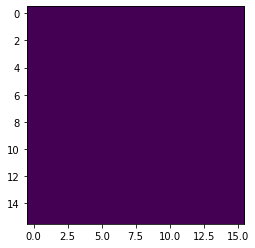

In [187]:
plt.imshow(env.maze)

In [195]:
np.array([x for x in rewards_v.values()]).reshape(el,el)

array([[ -4,  -4,  -4,  -4,  -1,  -2,  -3,  -4,  -1,  -2,  -3,  -4, -21,
        -22, -23, -24],
       [ -3,  -3,  -3,  -3,  -1,  -2,  -3,  -4,  -1,  -2,  -3,  -4, -21,
        -22, -23, -23],
       [ -2,  -2,  -2,  -2,  -1,  -2,  -3,  -4,  -1,  -2,  -3,  -4, -21,
        -22, -22, -22],
       [ -1,  -1,  -1,  -1,  -1,  -2,  -3,  -4,  -1,  -2,  -3,  -4, -21,
        -21, -21, -21],
       [ -4,  -4,  -4,  -4,  -1,  -2,  -3,  -4,  -4,  -4,  -4,  -4,  -4,
         -4,  -4,  -4],
       [ -3,  -3,  -3,  -3,  -1,  -2,  -3,  -4,  -3,  -3,  -3,  -3,  -3,
         -3,  -3,  -3],
       [ -2,  -2,  -2,  -2,  -1,  -2,  -3,  -4,  -2,  -2,  -2,  -2,  -2,
         -2,  -2,  -2],
       [ -1,  -1,  -1,  -1,  -1,  -2,  -3,  -4,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1],
       [ -4,  -4,  -4,  -4,  -1,  -2,  -3,  -4,  -1,  -2,  -3,  -4,  -1,
         -2,  -3,  -4],
       [ -3,  -3,  -3,  -3,  -1,  -2,  -3,  -4,  -1,  -2,  -3,  -4,  -1,
         -2,  -3,  -4],
       [ -2,  -2,  -2,  -2,  -

In [196]:
np.array([x for x in rewards_h.values()]).reshape(el,el)

array([[-12, -12, -12, -12, -13, -14, -15, -16, -17, -17, -17, -17, -17,
        -17, -17, -17],
       [-11, -11, -11, -11, -12, -13, -14, -15, -16, -17, -17, -17, -17,
        -17, -17, -17],
       [-10, -10, -10, -10, -11, -12, -13, -14, -15, -16, -17, -17, -17,
        -17, -17, -17],
       [ -9,  -9,  -9,  -9, -10, -11, -12, -13, -14, -15, -16, -17, -17,
        -17, -17, -17],
       [ -8,  -8,  -8,  -8,  -9, -10, -11, -12, -13, -14, -15, -16, -17,
        -17, -17, -17],
       [ -7,  -7,  -7,  -7,  -8,  -9, -10, -11, -12, -13, -14, -15, -16,
        -17, -17, -17],
       [ -6,  -6,  -6,  -6,  -7,  -8,  -9, -10, -11, -12, -13, -14, -15,
        -16, -17, -17],
       [ -5,  -5,  -5,  -5,  -6,  -7,  -8,  -9, -10, -11, -12, -13, -14,
        -15, -16, -17],
       [ -4,  -4,  -4,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12, -13,
        -14, -15, -16],
       [ -3,  -3,  -3,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
        -13, -14, -15],
       [ -2,  -2,  -2,  -2,  -

In [209]:
man_true_q_avg={}
man_true_q_max={}
man_true_q_min={}

In [210]:

for s in range(env.maze.shape[0]**2):
    z=[int(s/env.maze.shape[0]),s%env.maze.shape[0]]
    man=env.get_super_manager_1(z)[1]
    man=man[0]*4+man[1]
    try:
        man_true_q_avg[man]=man_true_q_avg[man]+rewards_h[s]
        if rewards_h[s]>man_true_q_max[man]:
            man_true_q_max[man]=rewards_h[s]
        if rewards_h[s]<man_true_q_min[man]:
            man_true_q_min[man]=rewards_h[s]
        
        
    except:
        man_true_q_avg[man]=rewards_h[s]
        man_true_q_max[man]=rewards_h[s]
        man_true_q_min[man]=rewards_h[s]
man_true_q_avg={x:man_true_q_avg[x]/((env.maze.shape[0]/env.manager_view)**2) for x in man_true_q_avg.keys()}
# man_true_q_avg={x:man_true_q_avg[x]/4 for x in man_true_q_avg.keys()}

In [211]:
np.array([x for x in man_true_q_avg.values()]).reshape(4,4)

array([[-10.5  , -13.   , -16.375, -17.   ],
       [ -6.5  ,  -9.   , -13.   , -16.375],
       [ -2.5  ,  -5.   ,  -9.   , -13.   ],
       [  0.   ,  -2.5  ,  -6.5  , -10.5  ]])

In [212]:
np.array([x for x in man_true_q_max.values()]).reshape(4,4)

array([[ -9, -10, -14, -17],
       [ -5,  -6, -10, -14],
       [ -1,  -2,  -6, -10],
       [  0,  -1,  -5,  -9]])

In [213]:
np.array([x for x in man_true_q_min.values()]).reshape(4,4)

array([[-12, -16, -17, -17],
       [ -8, -12, -16, -17],
       [ -4,  -8, -12, -16],
       [  0,  -4,  -8, -12]])

In [208]:
(env.maze.shape[0]/env.manager_view)**2

16.0